# EQUIX: Jq divergence

In [2]:
%load_ext watermark
%matplotlib inline


import glob
import os

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dcpy.oceans import read_osu_microstructure_mat
from IPython.display import Image

#import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

%watermark -iv

dcpy       : 0.1
xarray     : 0.17.1.dev3+g48378c4b1
pump       : 0.1
numpy      : 1.21.1
distributed: 2021.7.2
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
matplotlib : 3.4.2



## Read data

In [16]:
#th = xr.load_dataset("/home/deepak/datasets/microstructure/osu/tropicheat.nc")
#tiwe = xr.load_dataset("/home/deepak/datasets/microstructure/osu/tiwe.nc")
equix = xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix.nc")

for var in equix:
    equix[var].attrs["coordinates"] = " ".join(equix[var].dims)
equix.pden.attrs["standard_name"] = "sea_water_potential_density"
equix.pres.attrs["positive"] = "down"

iop = xr.open_dataset(
    "/home/deepak/work/datasets/microstructure/osu/equix/hourly_iop.nc"
)
eop = xr.open_dataset(
    "/home/deepak/work/datasets/microstructure/osu/equix/hourly_eop.nc"
)

## Chameleon $w_{ci}$ estimate

Following Winters & D'Asaro (1996) §7. 

Take a group of profiles (e.g. 3 hours or a day, with approx. 6 profiles per hour), and choose temperature bin edges $θ_{bin} = θ_f$ ("theta at faces")


1. Calculate dT/dz: Identify pressure of each $θ_{f}$, find mean $Δp$ between each pair of bins in this group of profiles (mean distance between isotherms), then $⟨T⟩_z = Δθ_{f}/Δp$ at $θ_c$ ("theta centers")
1. Calculate heat flux $J_q = ρ c_p ⟨χ⟩/2/⟨T⟩_z$ at $θ_f$, where $⟨χ⟩$ is 0.5m χ averaged in temperature bins. 
1. Calculate $w_{ci} = 1/(ρc_p) ΔJ_q/Δθ_c$


TODO:
1. Check mld estimate
2. Ignore bin averages when number of observations is "small"

#### Choosing bins

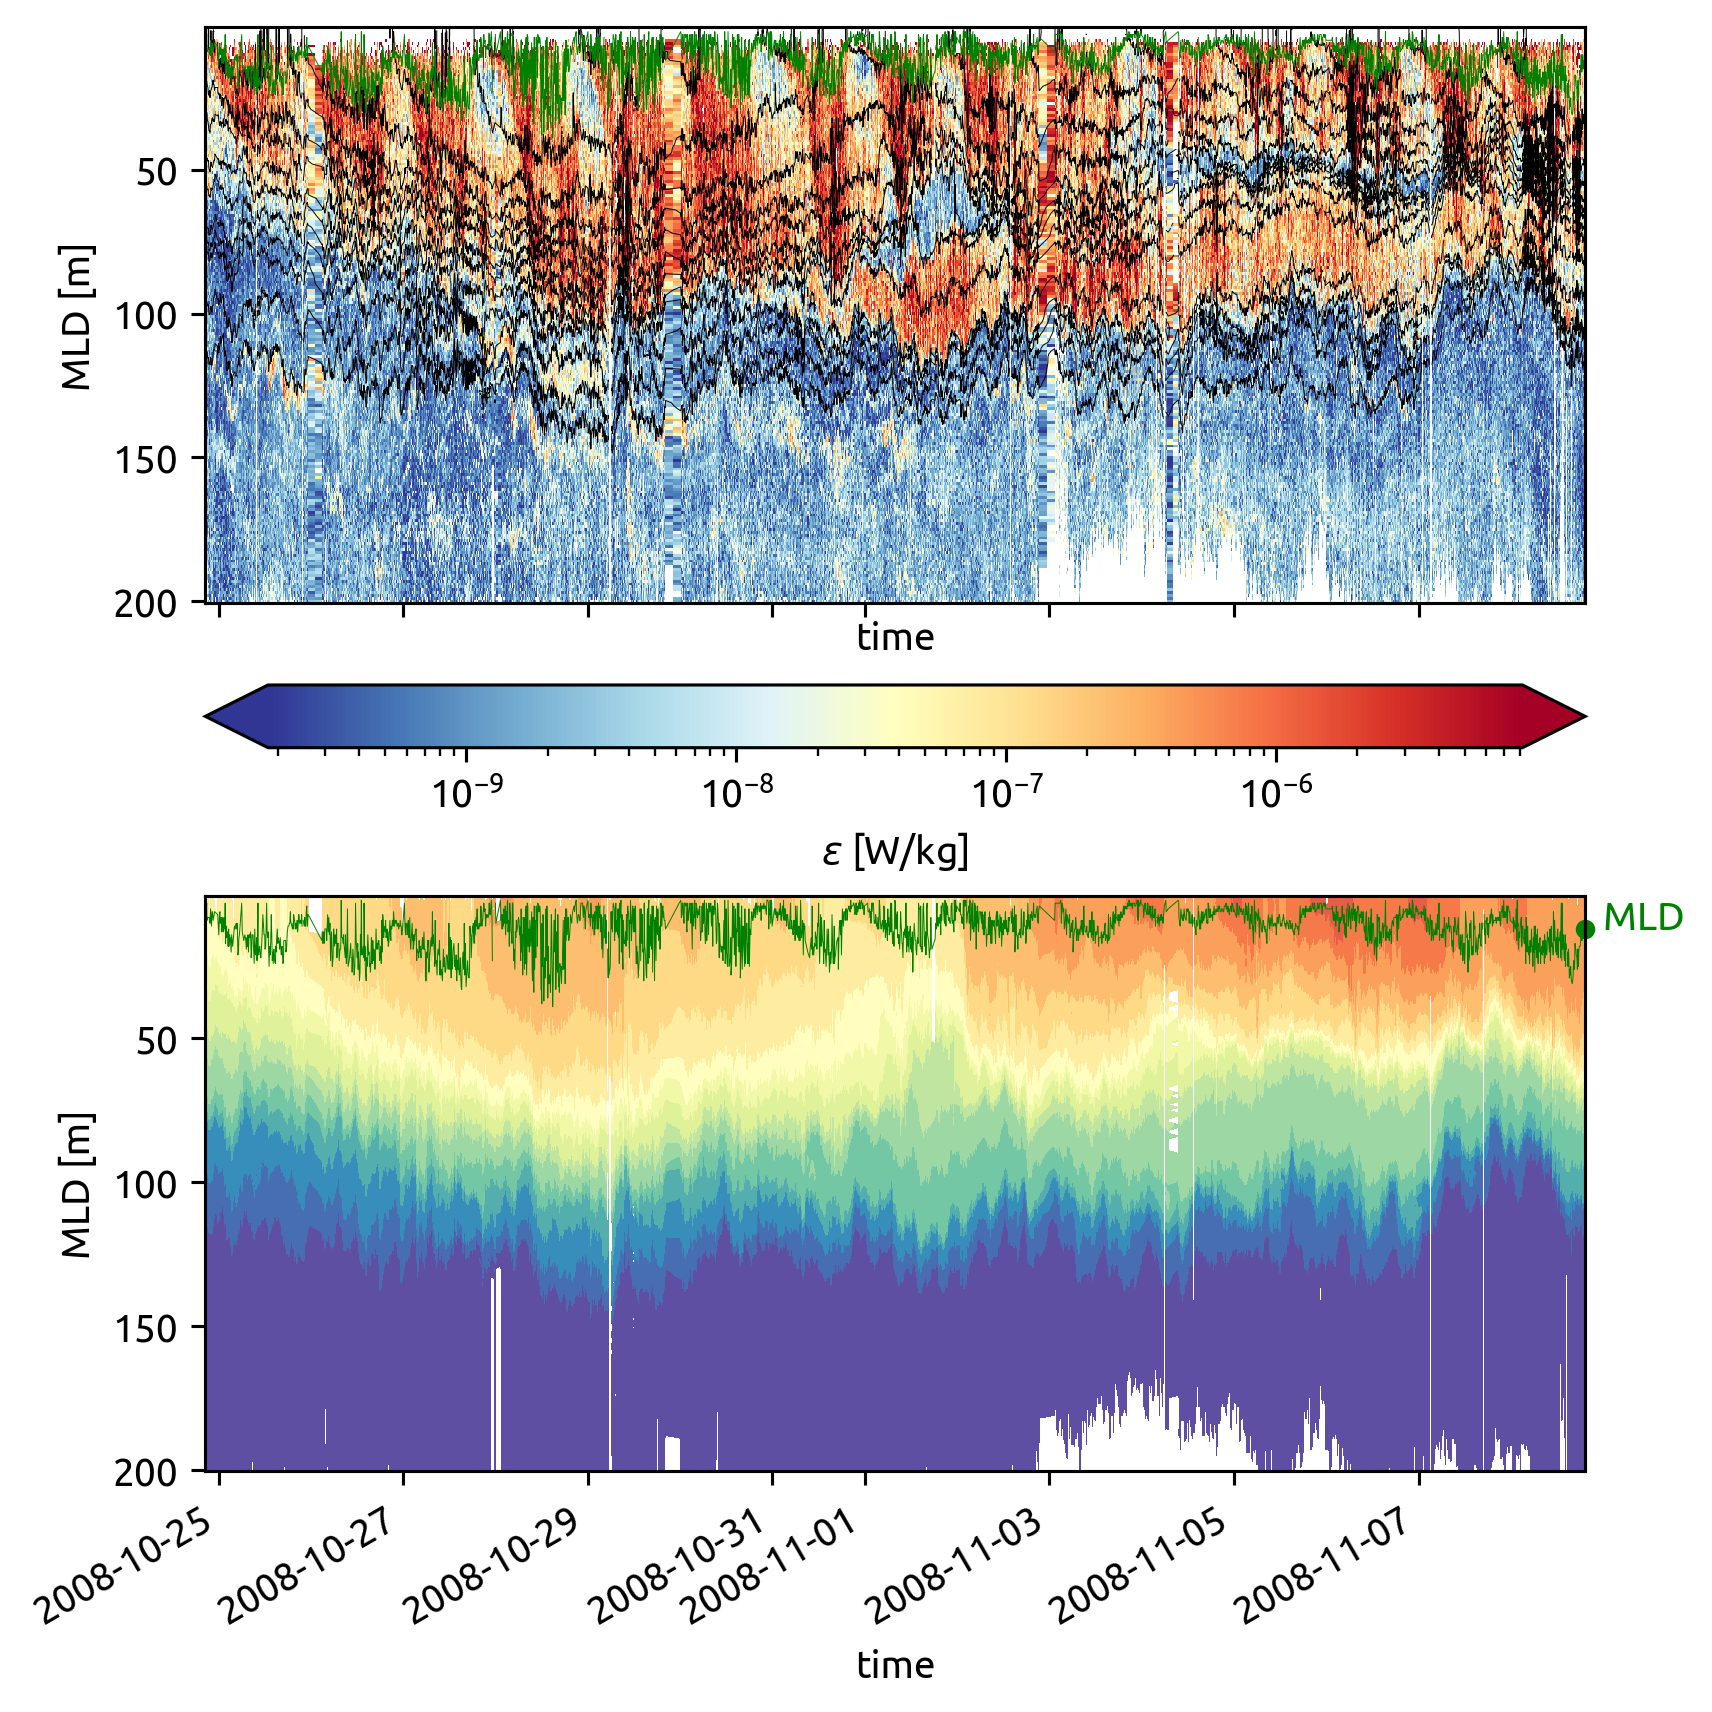

In [82]:
bins = np.hstack([np.arange(18, 23, 1), np.arange(23, 24, 0.5), np.arange(24, 27, 0.25)])

f, ax = plt.subplots(2, 1, sharex=True, sharey=True, constrained_layout=True)

equix.eps.cf.plot(
    x="time",
    cmap=mpl.cm.RdYlBu_r,
    norm=mpl.colors.LogNorm(),
    robust=True,
    ax=ax[0],
    cbar_kwargs={"orientation": "horizontal"},
)
equix.theta.cf.plot.contour(
    levels=bins, colors="k", linewidths=0.25, x="time", ax=ax[0]
)
equix.mld.plot(color="g", ax=ax[0], lw=0.25)

equix.theta.cf.plot.contourf(
    x="time",
    cmap=mpl.cm.Spectral_r,
    vmin=bins[0],
    vmax=bins[-1],
    levels=bins,
    ax=ax[1],
    add_colorbar=False,
)
hdl = equix.mld.plot(color="g", ax=ax[1], lw=0.25)
dcpy.plots.annotate_end(hdl[0], "MLD")

f.set_size_inches((6, 6))

### Example: 1 Day average

First panel shows mean θ (simple time average) in blue and the reconstructed T profile in orange. Not sure if I should be worried about the difference.

Second panel shows $J_q$ (blue) and $∂J/∂z$ in red (signed so that positive means heating).

Third panel is wci due to shear

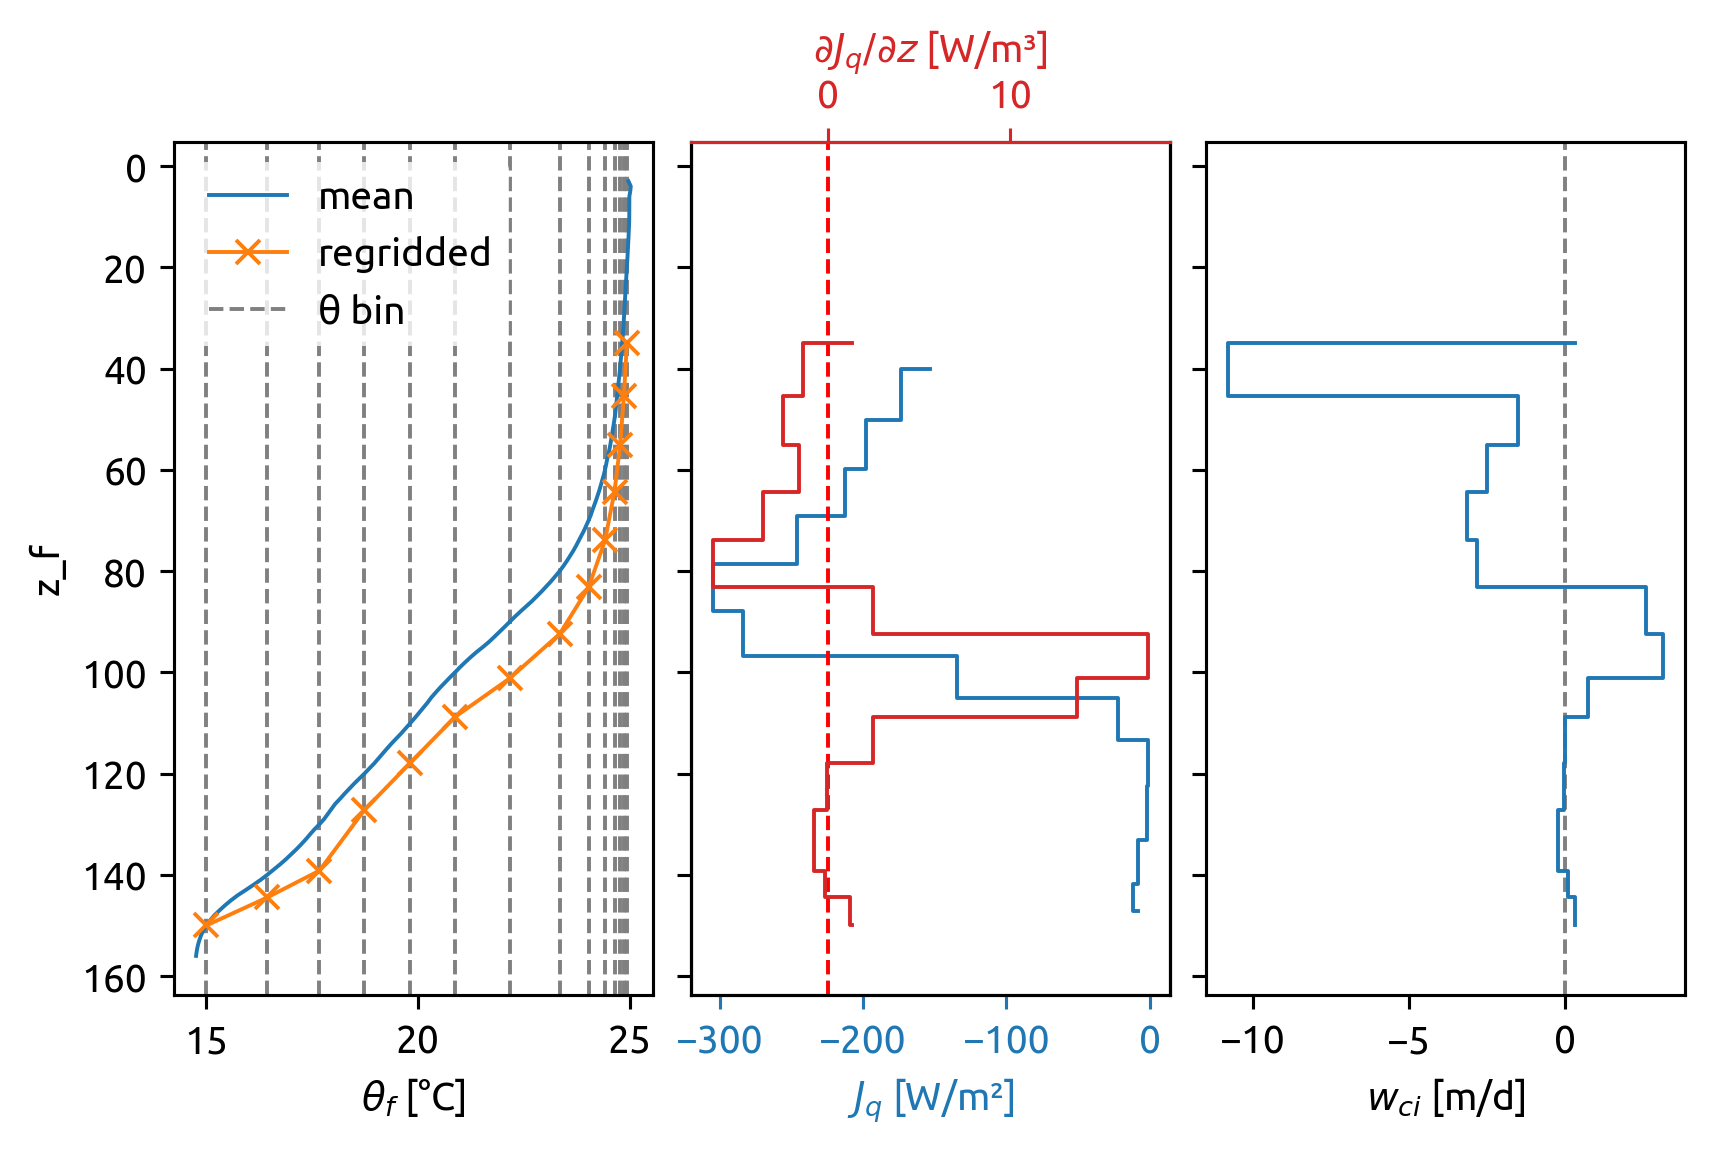

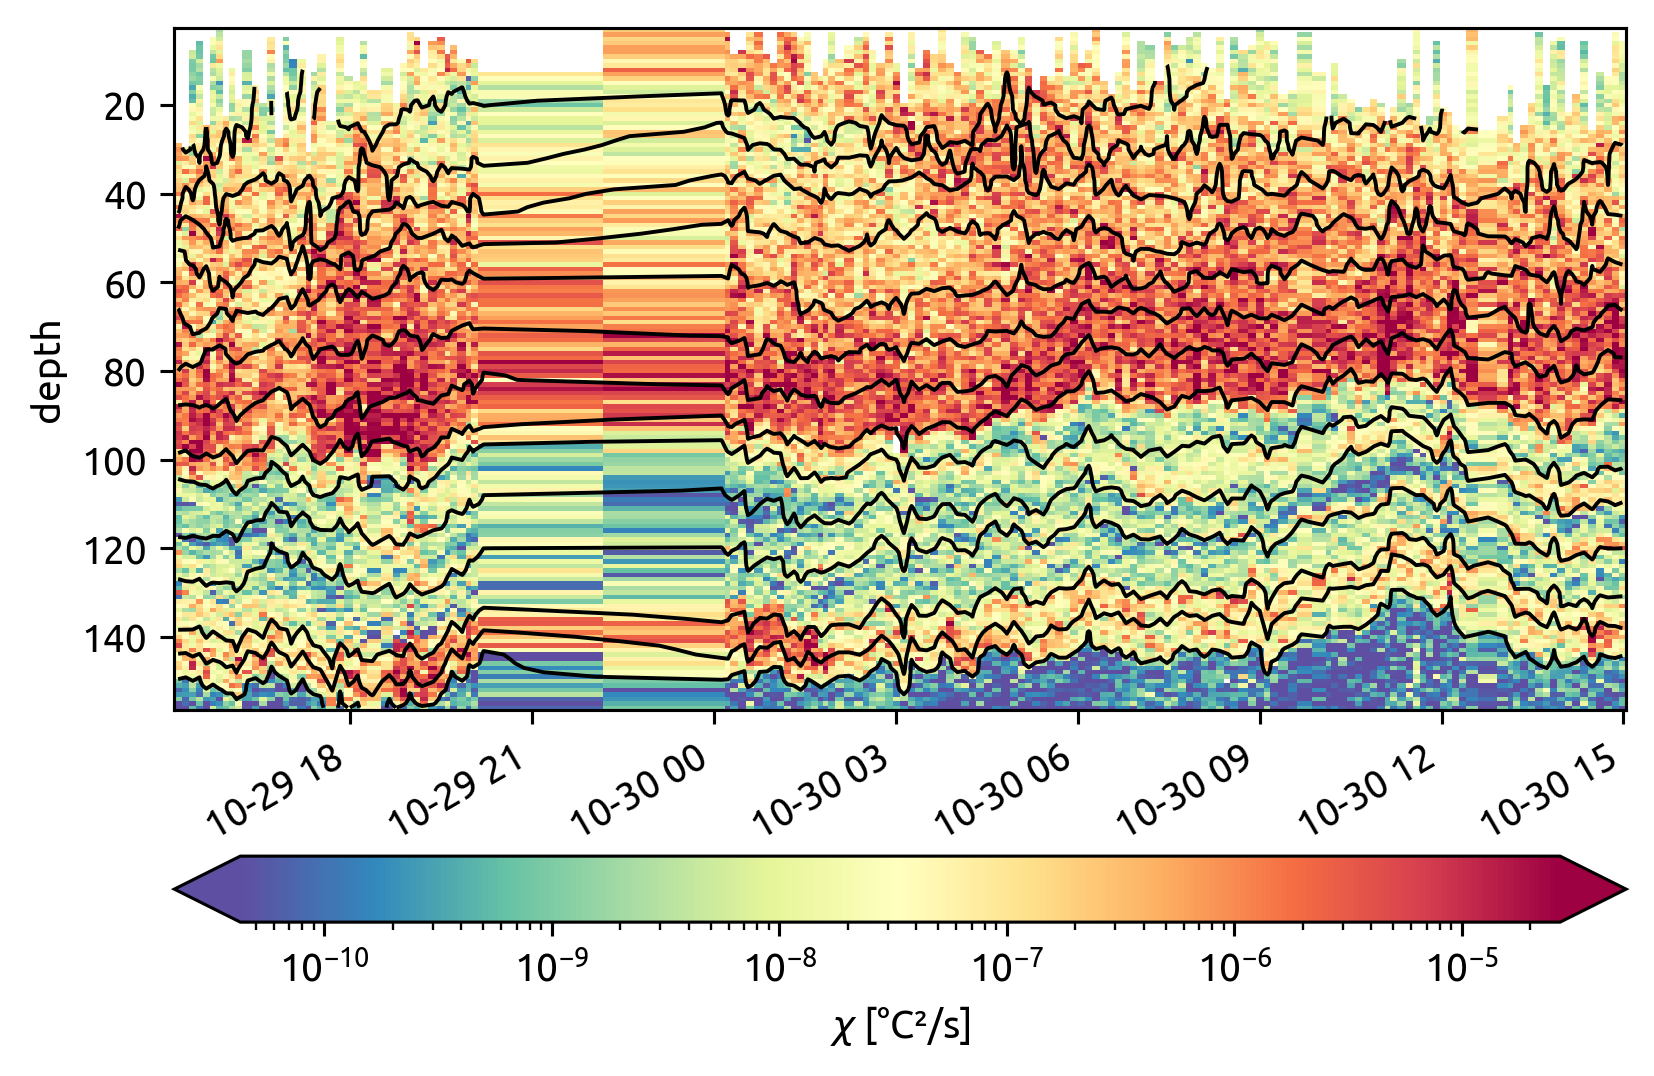

In [83]:
profiles = equix.sel(
    time=slice("2008-10-29 15:00", "2008-10-30 15:00"), depth=slice(156)
)
profiles = profiles.where(profiles.depth > profiles.mld)
result = pump.tspace.regrid_chameleon_(profiles, debug=True, trim_mld=False)

### All data: 3 hour average

Here I use 3 hour averages for all the data. Exlude mld+5m to account for some uncertainty in finding MLD. I think it's too noisy, could be improved.

In [84]:
equixT = pump.tspace.regrid_chameleon(
    equix.sel(depth=slice(156)).where(equix.depth > equix.mld + 5),
    time_freq="3H",
    bins=bins,
    trim_mld=False,
)

This summary plot shows ε for the full record and wci.

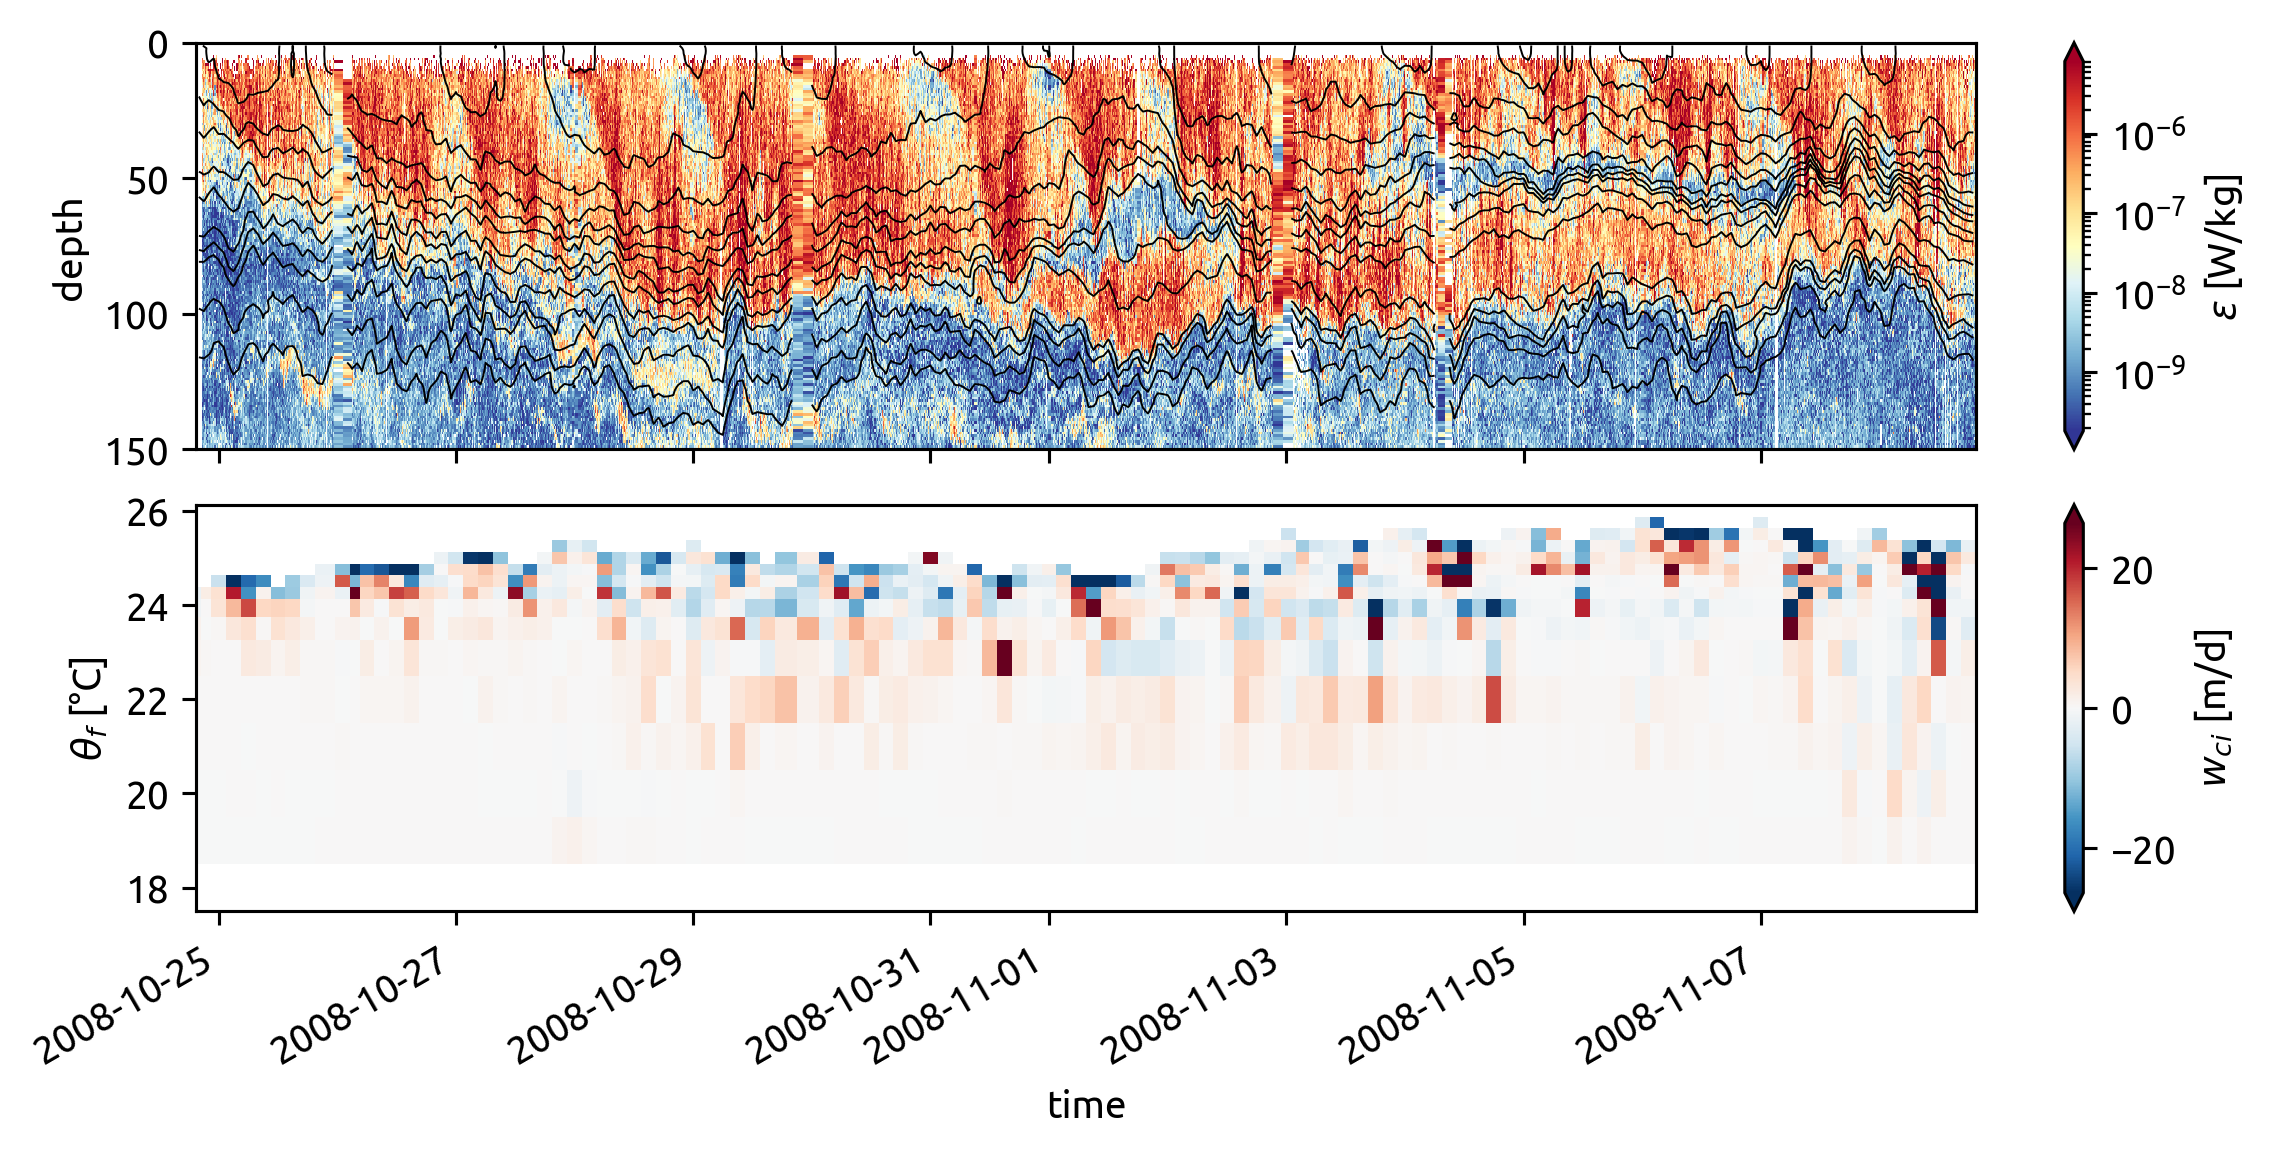

In [85]:
f, ax = plt.subplots(2, 1, sharex=True, squeeze=False, constrained_layout=True)
equix.eps.cf.plot(
    x="time", cmap=mpl.cm.RdYlBu_r, norm=mpl.colors.LogNorm(), robust=True, ax=ax[0, 0]
)
# equix.dJdz.cf.plot(
#    x="time", cmap=mpl.cm.RdBu, vmin=-10, vmax=10, ax=ax[0, 0]
# )
equix.theta.resample(time="H").mean().cf.plot.contour(
    levels=equixT.theta_f, colors="k", linewidths=0.5, x="time", ax=ax[0, 0], ylim=(150, 0)
)
equixT.wci.sel(theta_f=slice(None, 26)).plot(x="time", robust=True, ax=ax[1, 0])

dcpy.plots.clean_axes(ax)
f.set_size_inches((8, 4))

### All data: daily average

I'm using a daily average starting at midnight.

In [86]:
equixT = pump.tspace.regrid_chameleon(
    equix.sel(depth=slice(156)).where(equix.depth > equix.mld + 5),
    time_freq="1D",
    bins=bins,
    trim_mld=False,
)

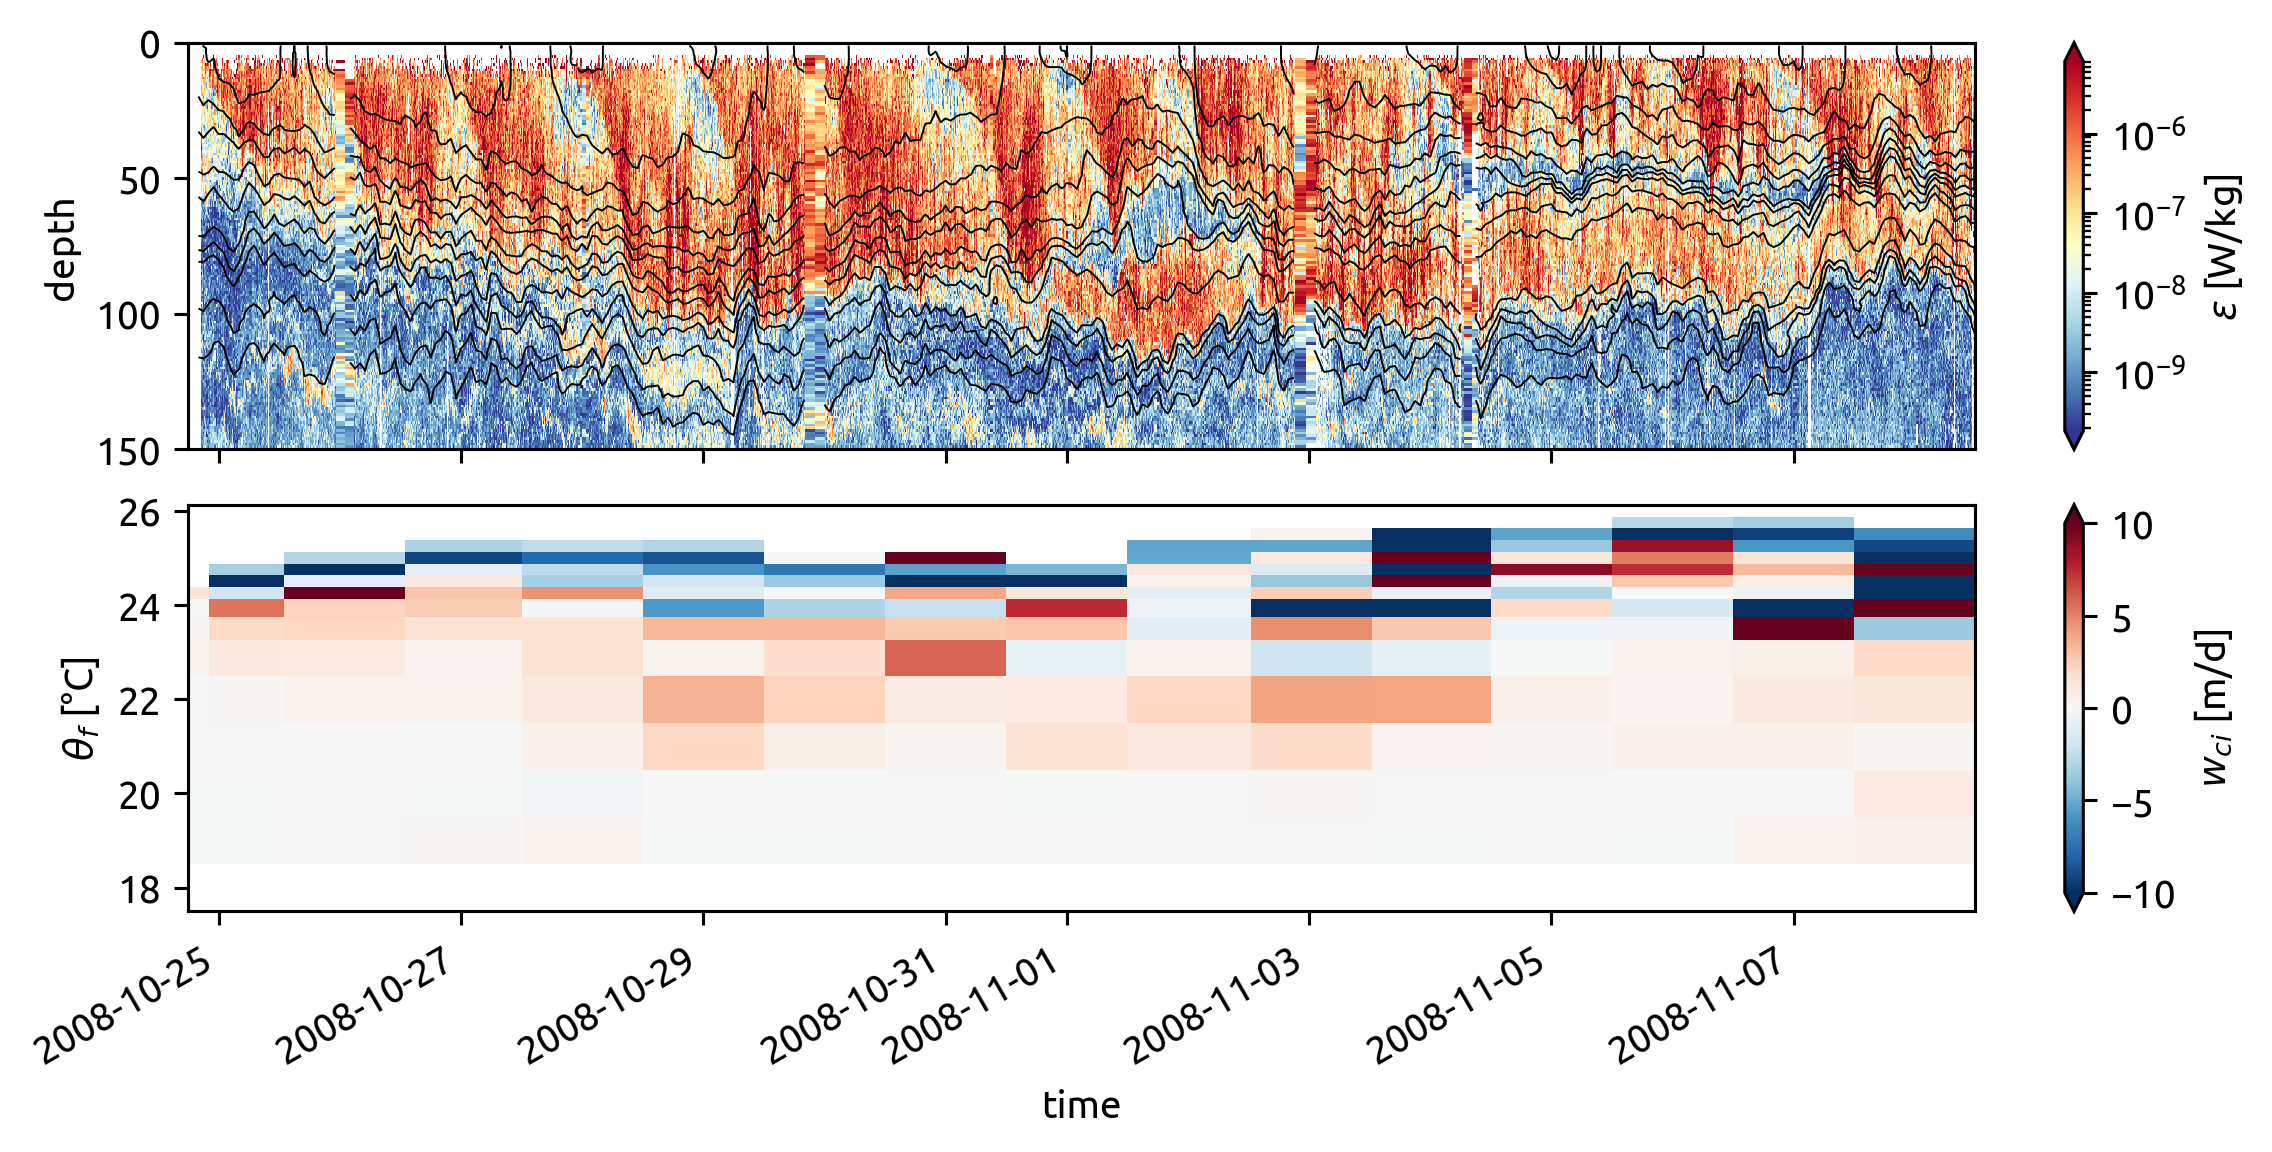

In [87]:
f, ax = plt.subplots(2, 1, sharex=True, squeeze=False, constrained_layout=True)
equix.eps.cf.plot(
    x="time", cmap=mpl.cm.RdYlBu_r, norm=mpl.colors.LogNorm(), robust=True, ax=ax[0, 0]
)
# equix.dJdz.cf.plot(
#    x="time", cmap=mpl.cm.RdBu, vmin=-10, vmax=10, ax=ax[0, 0]
# )
equix.theta.resample(time="H").mean().cf.plot.contour(
    levels=equixT.theta_f, colors="k", linewidths=0.5, x="time", ax=ax[0, 0], ylim=(150, 0)
)
equixT.wci.sel(theta_f=slice(None, 26)).plot(x="time", vmin=-10,  ax=ax[1, 0])

dcpy.plots.clean_axes(ax)
f.set_size_inches((8, 4))

### All data: 5-day average

Maybe this is comparable to POP2?

In [88]:
equixT = pump.tspace.regrid_chameleon(
    equix.sel(depth=slice(156)).where(equix.depth > equix.mld + 5),
    time_freq="5D",
    bins=bins,
    trim_mld=False,
)

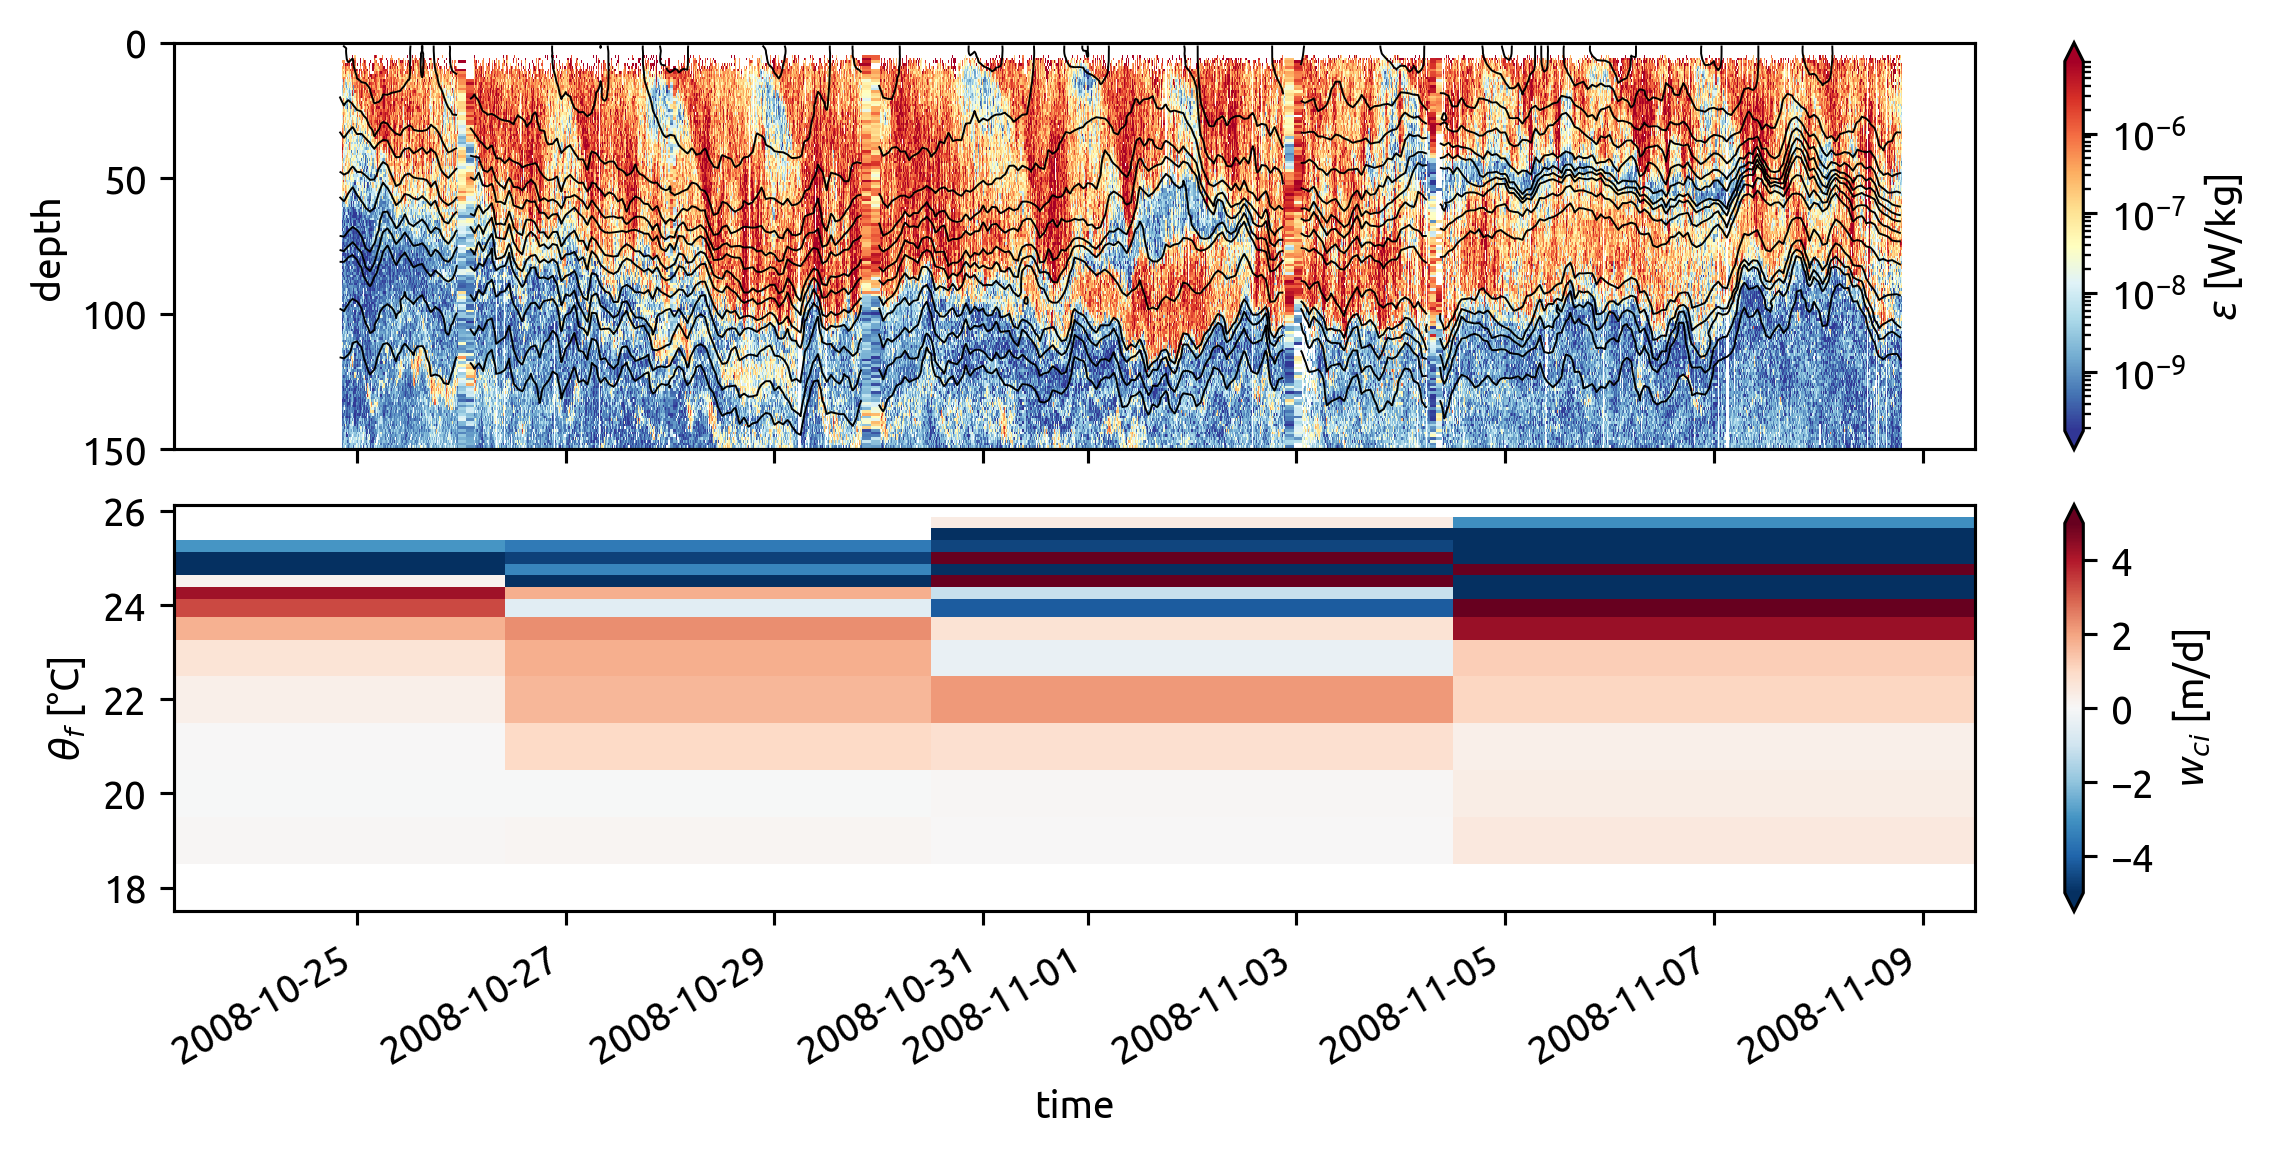

In [90]:
f, ax = plt.subplots(2, 1, sharex=True, squeeze=False, constrained_layout=True)
equix.eps.cf.plot(
    x="time", cmap=mpl.cm.RdYlBu_r, norm=mpl.colors.LogNorm(), robust=True, ax=ax[0, 0]
)
# equix.dJdz.cf.plot(
#    x="time", cmap=mpl.cm.RdBu, vmin=-10, vmax=10, ax=ax[0, 0]
# )
equix.theta.resample(time="H").mean().cf.plot.contour(
    levels=equixT.theta_f, colors="k", linewidths=0.5, x="time", ax=ax[0, 0], ylim=(150, 0)
)
equixT.wci.sel(theta_f=slice(None, 26)).plot(x="time", vmin=-5,  ax=ax[1, 0])

dcpy.plots.clean_axes(ax)
f.set_size_inches((8, 4))

### Conservative regridding

I think I'm losing heat when reconstructing the profile with mean ∂T/∂z! but this conservative thing gives a smaller spacing. I think there's a bug

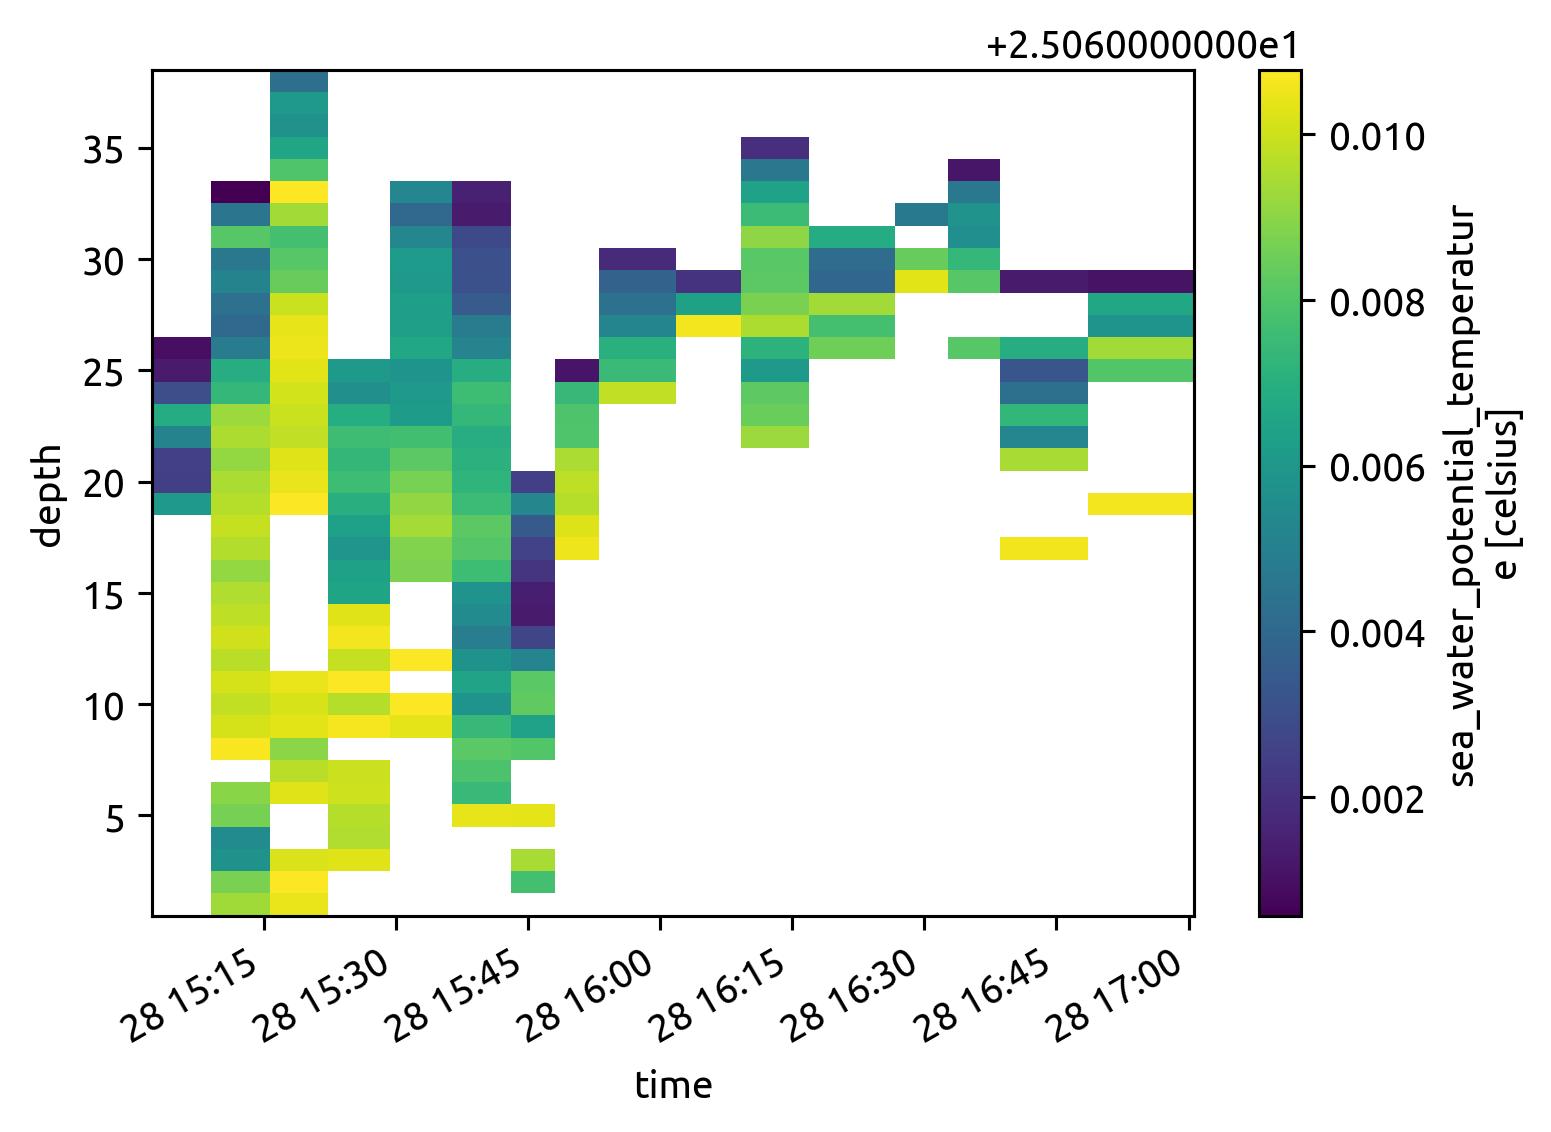

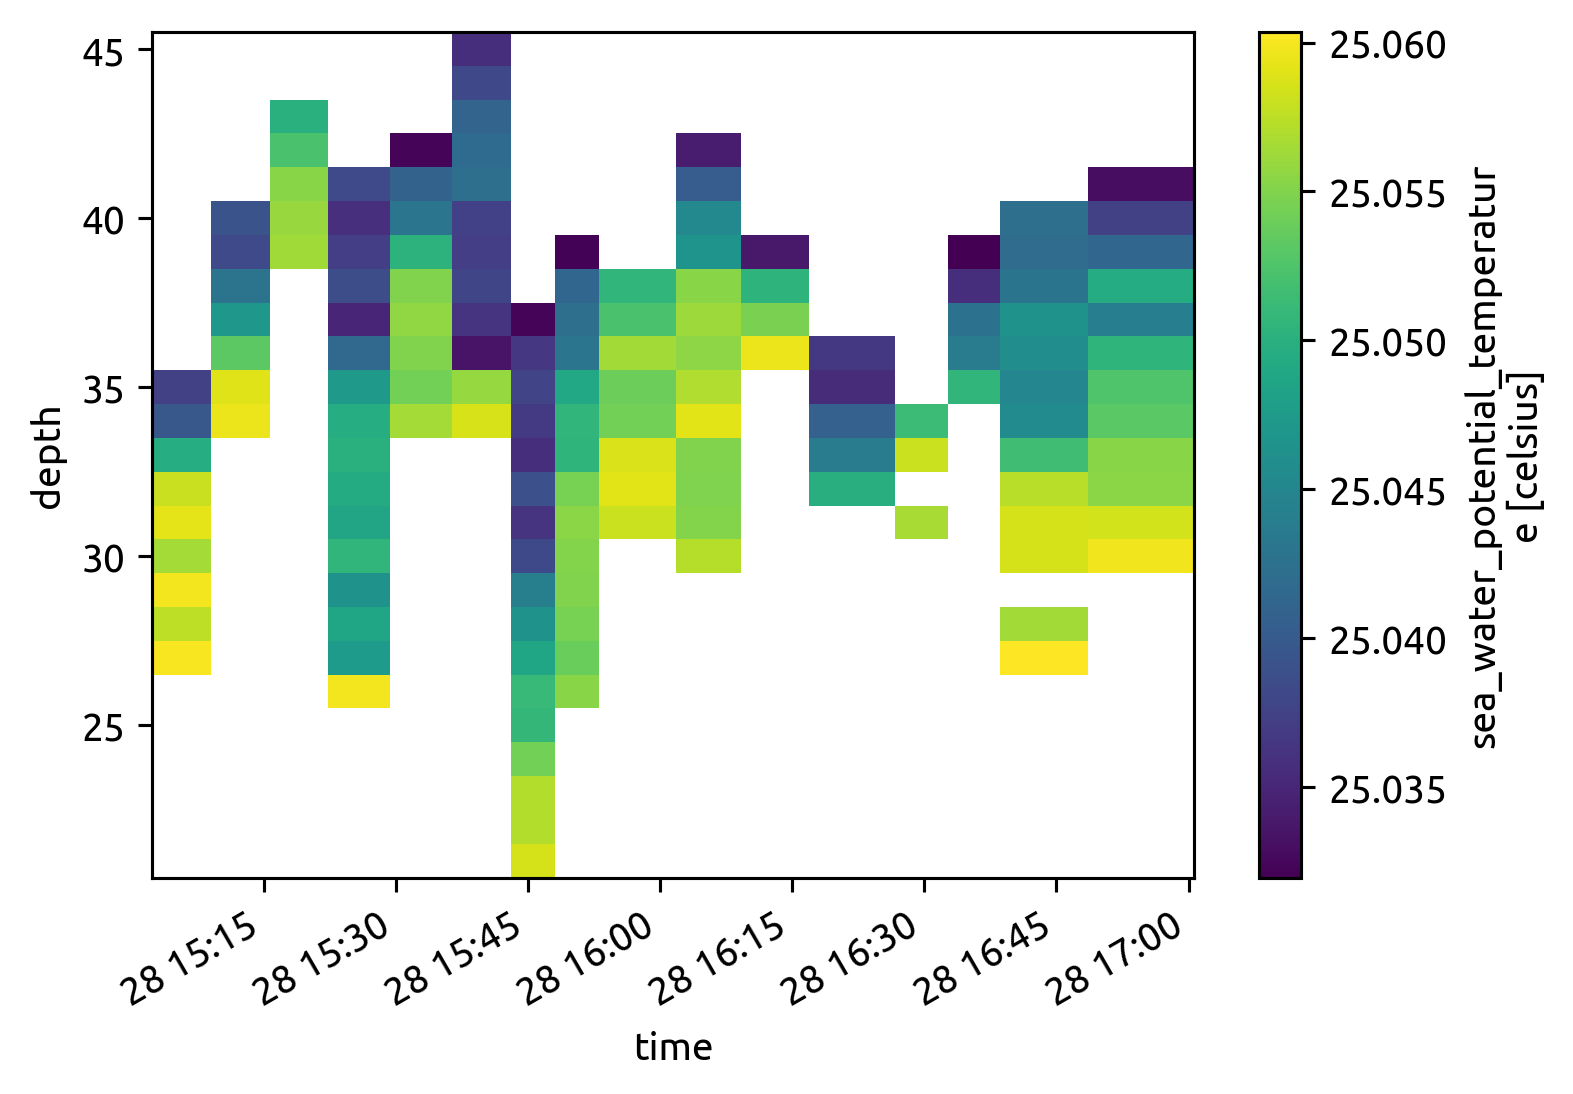

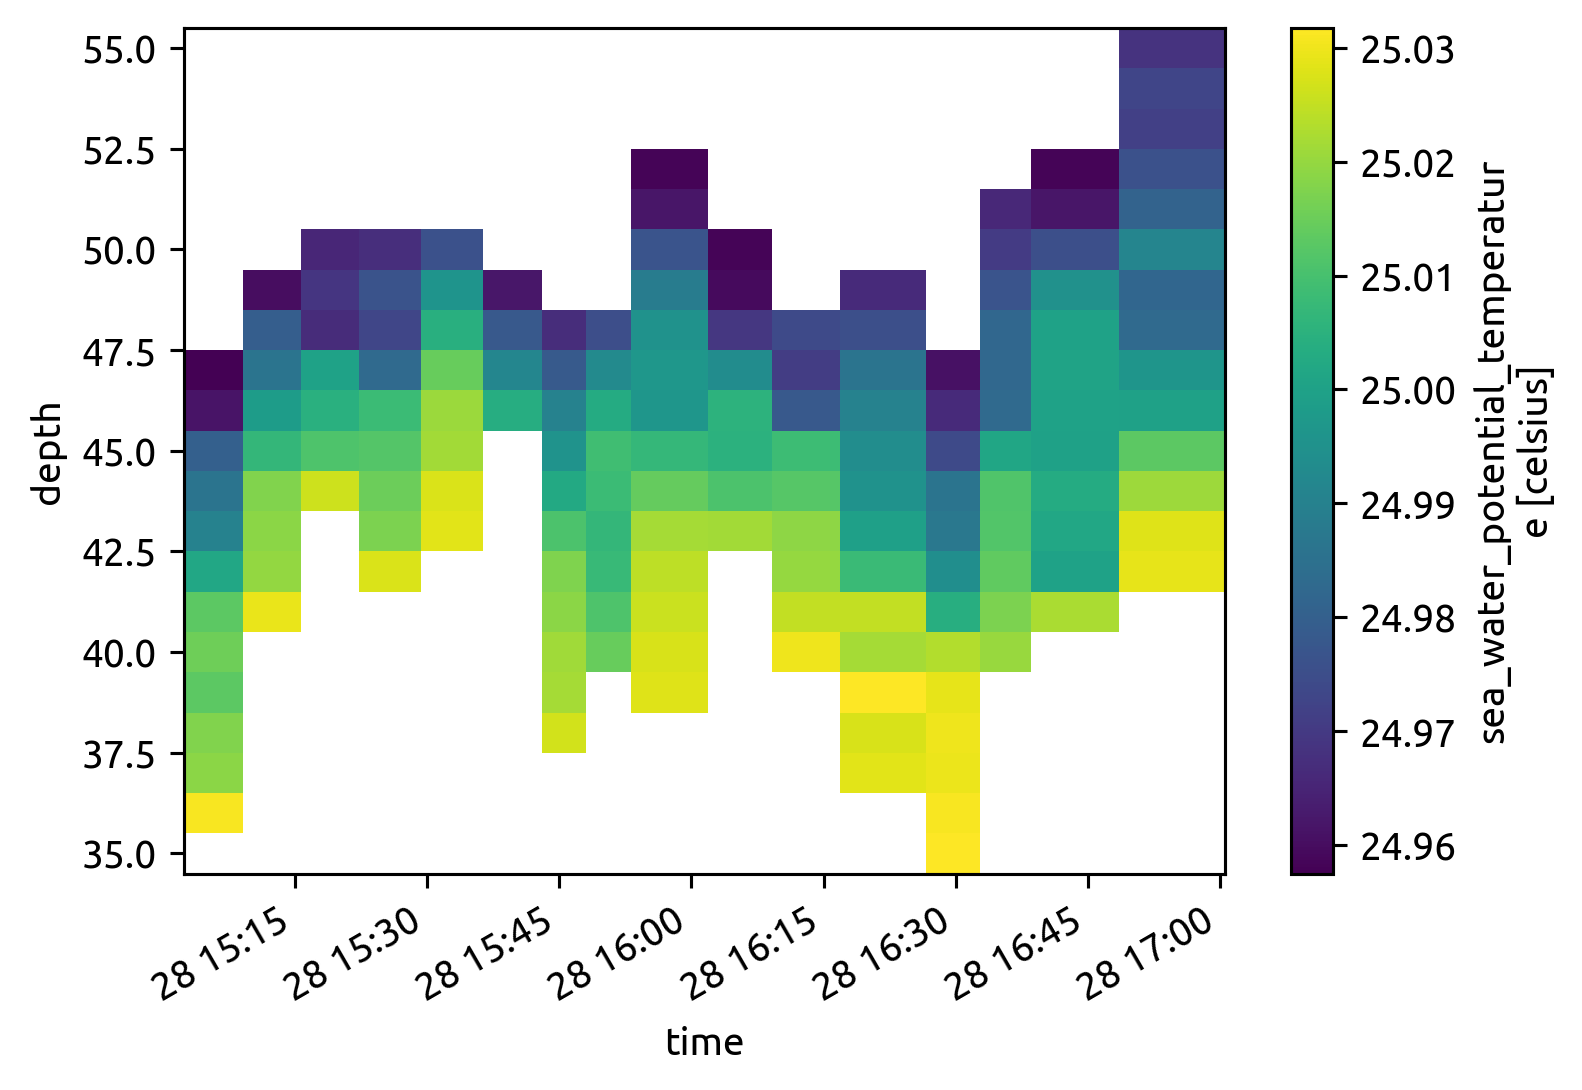

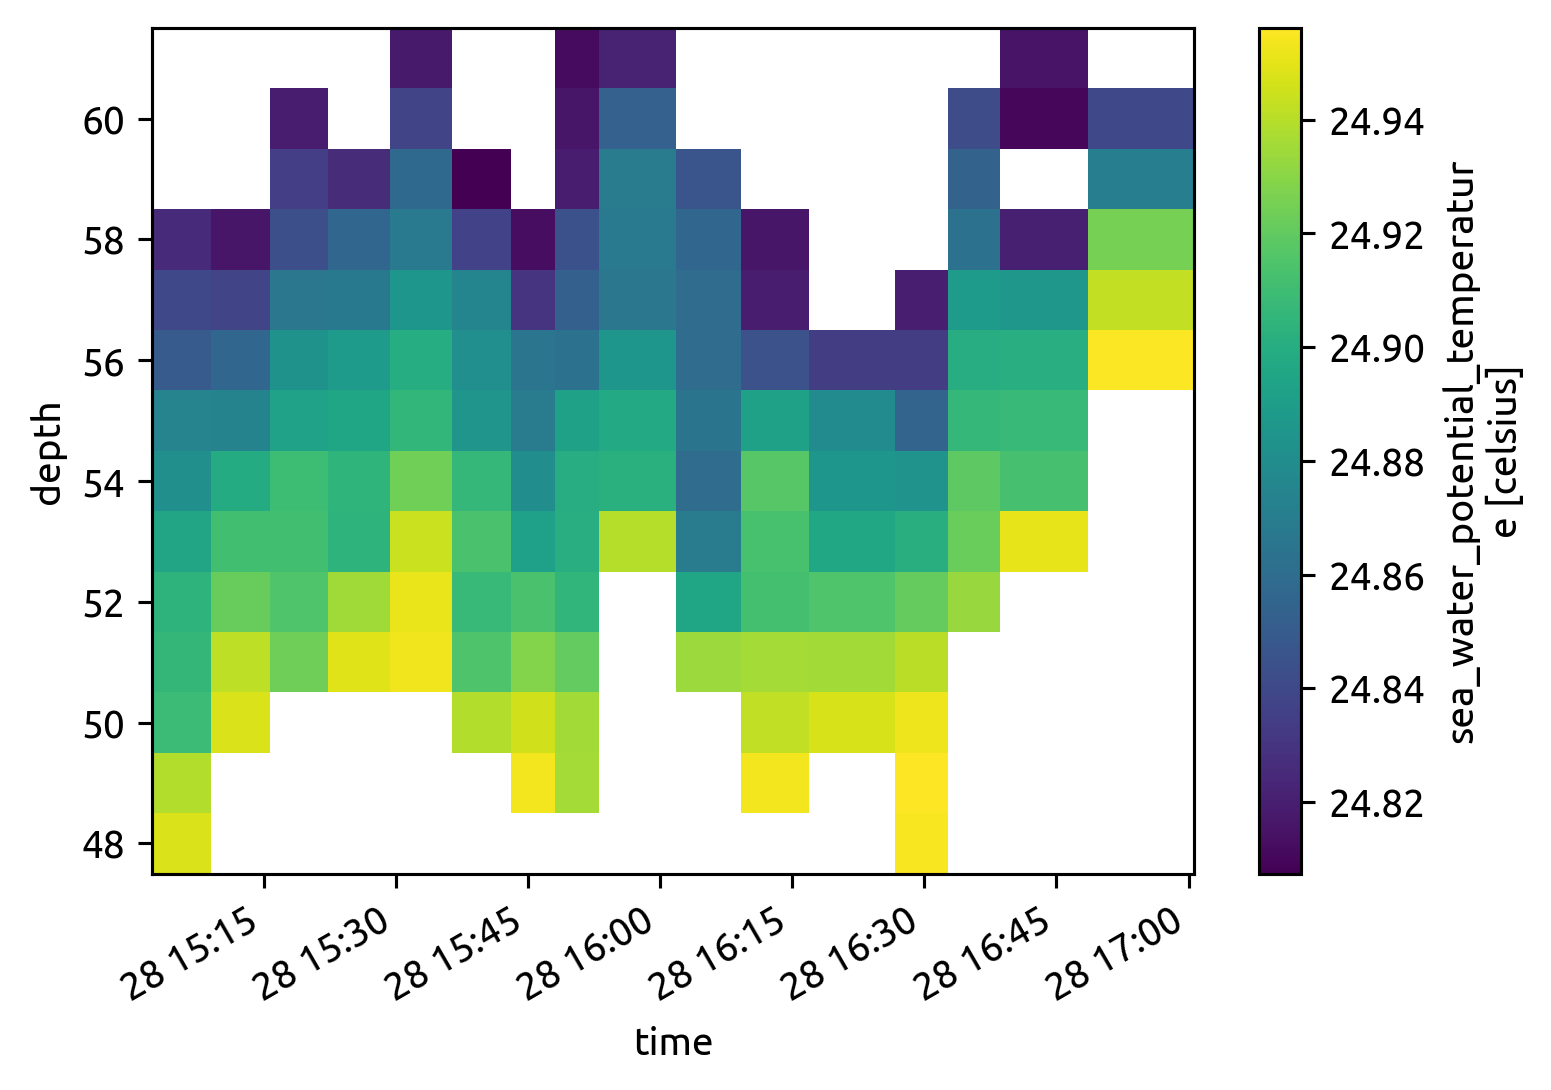

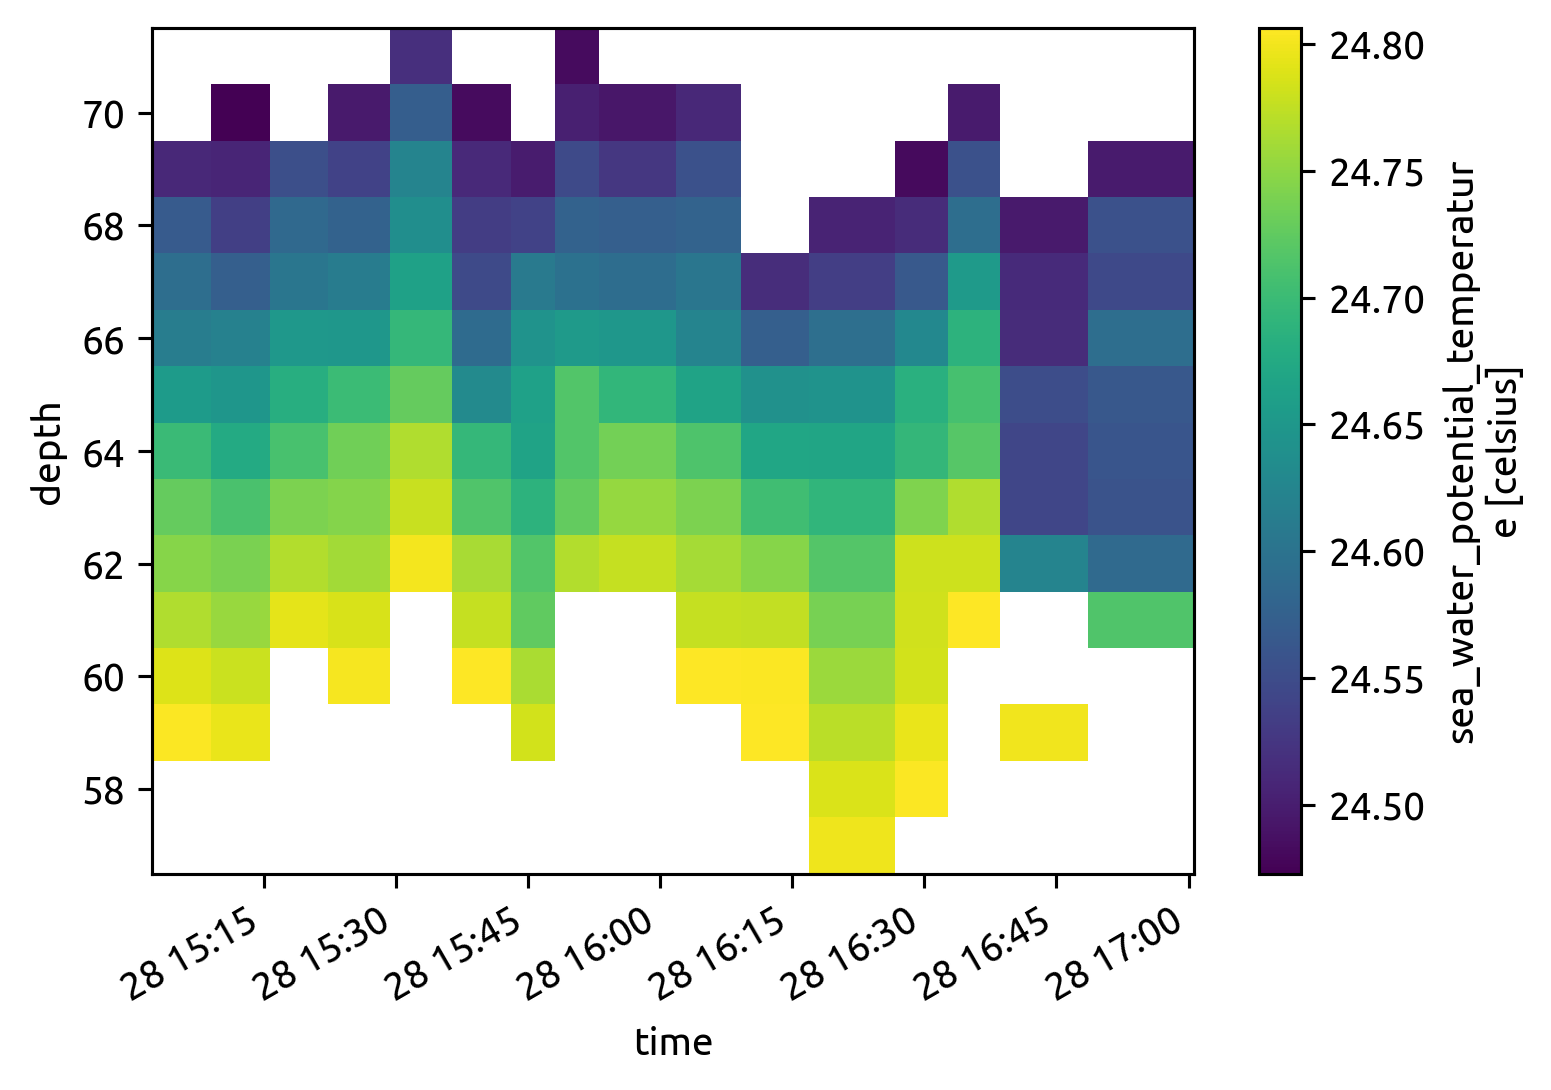

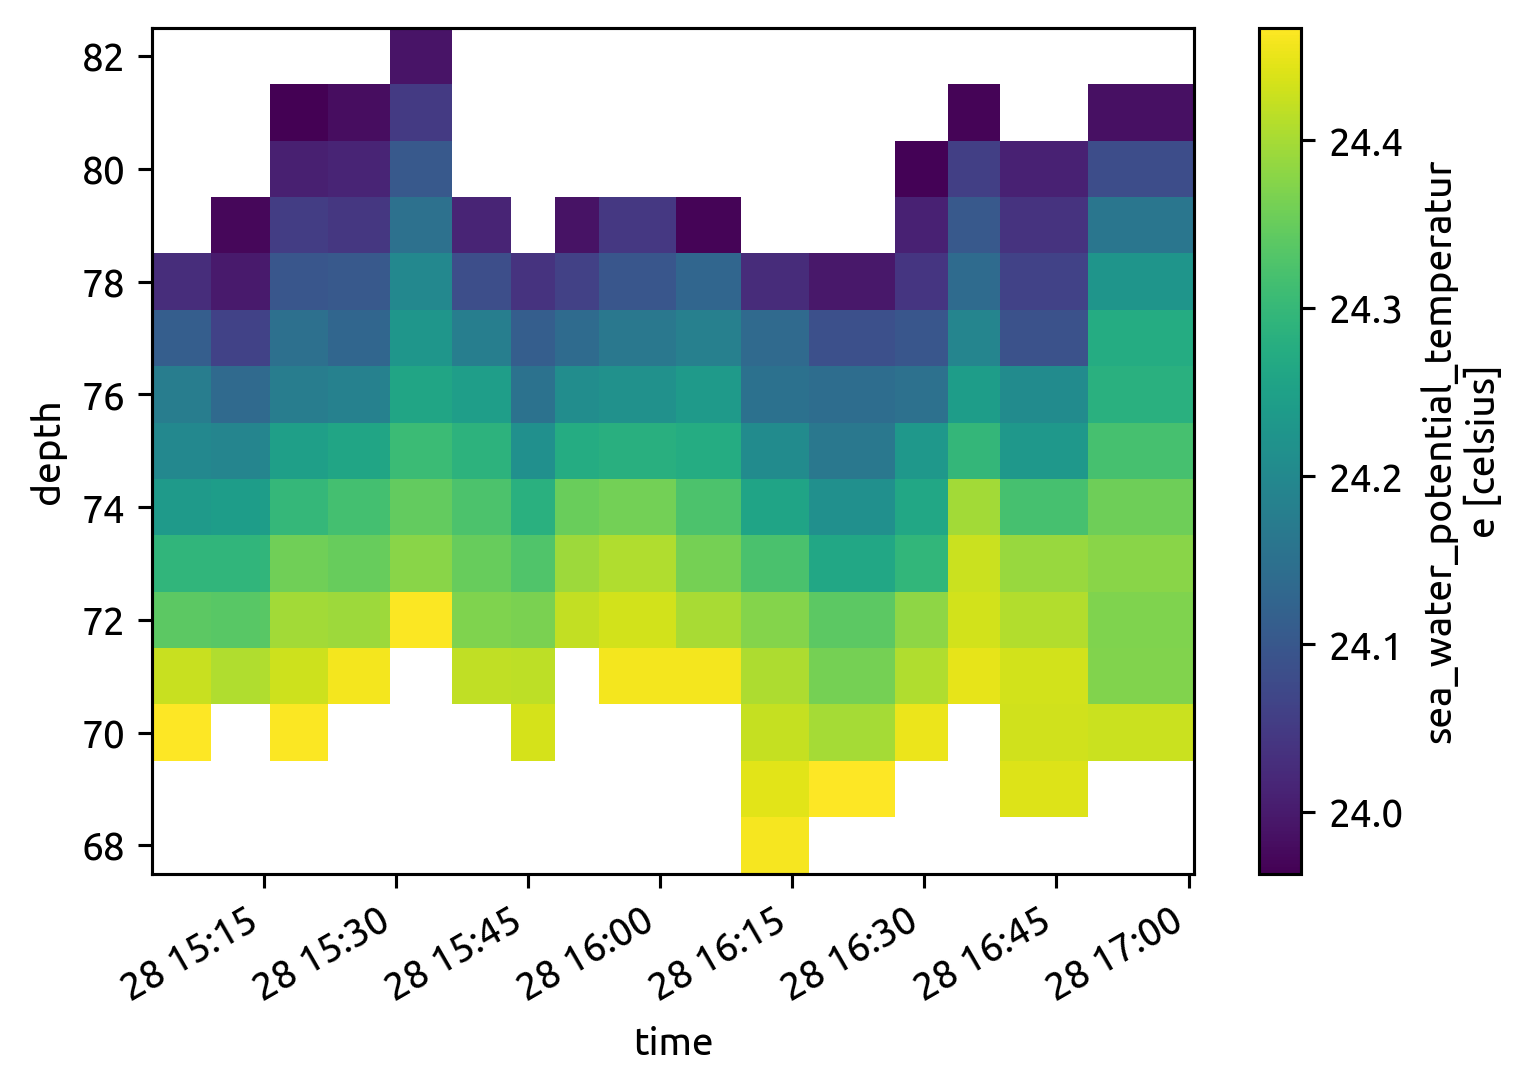

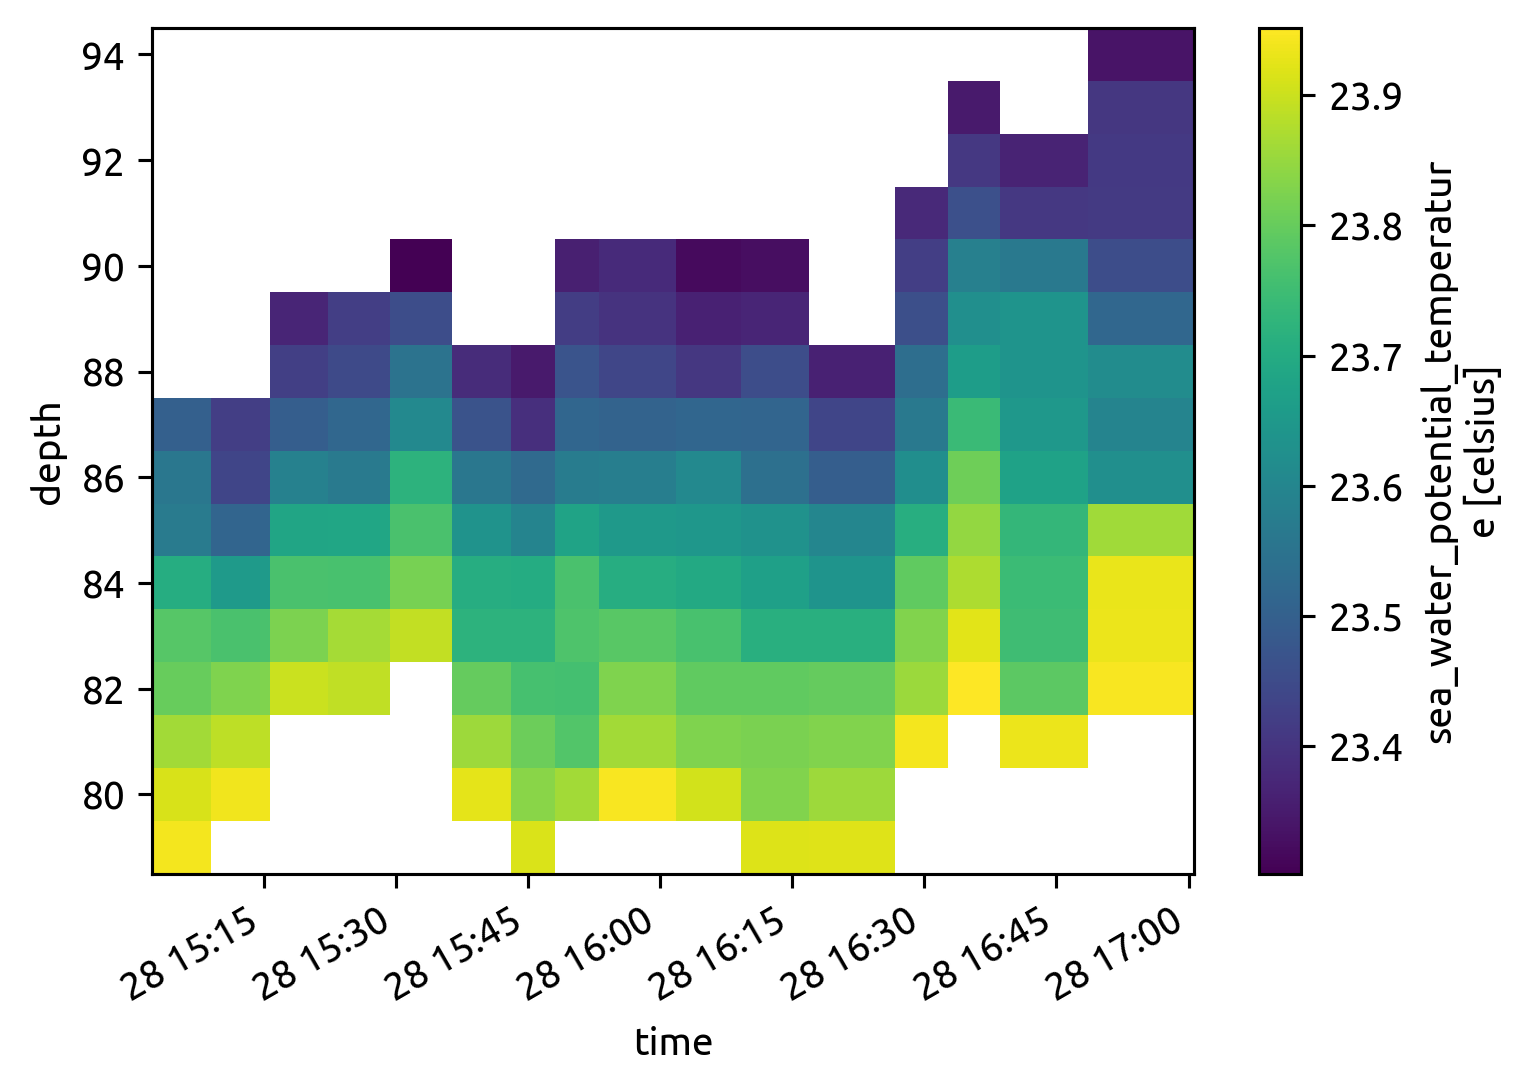

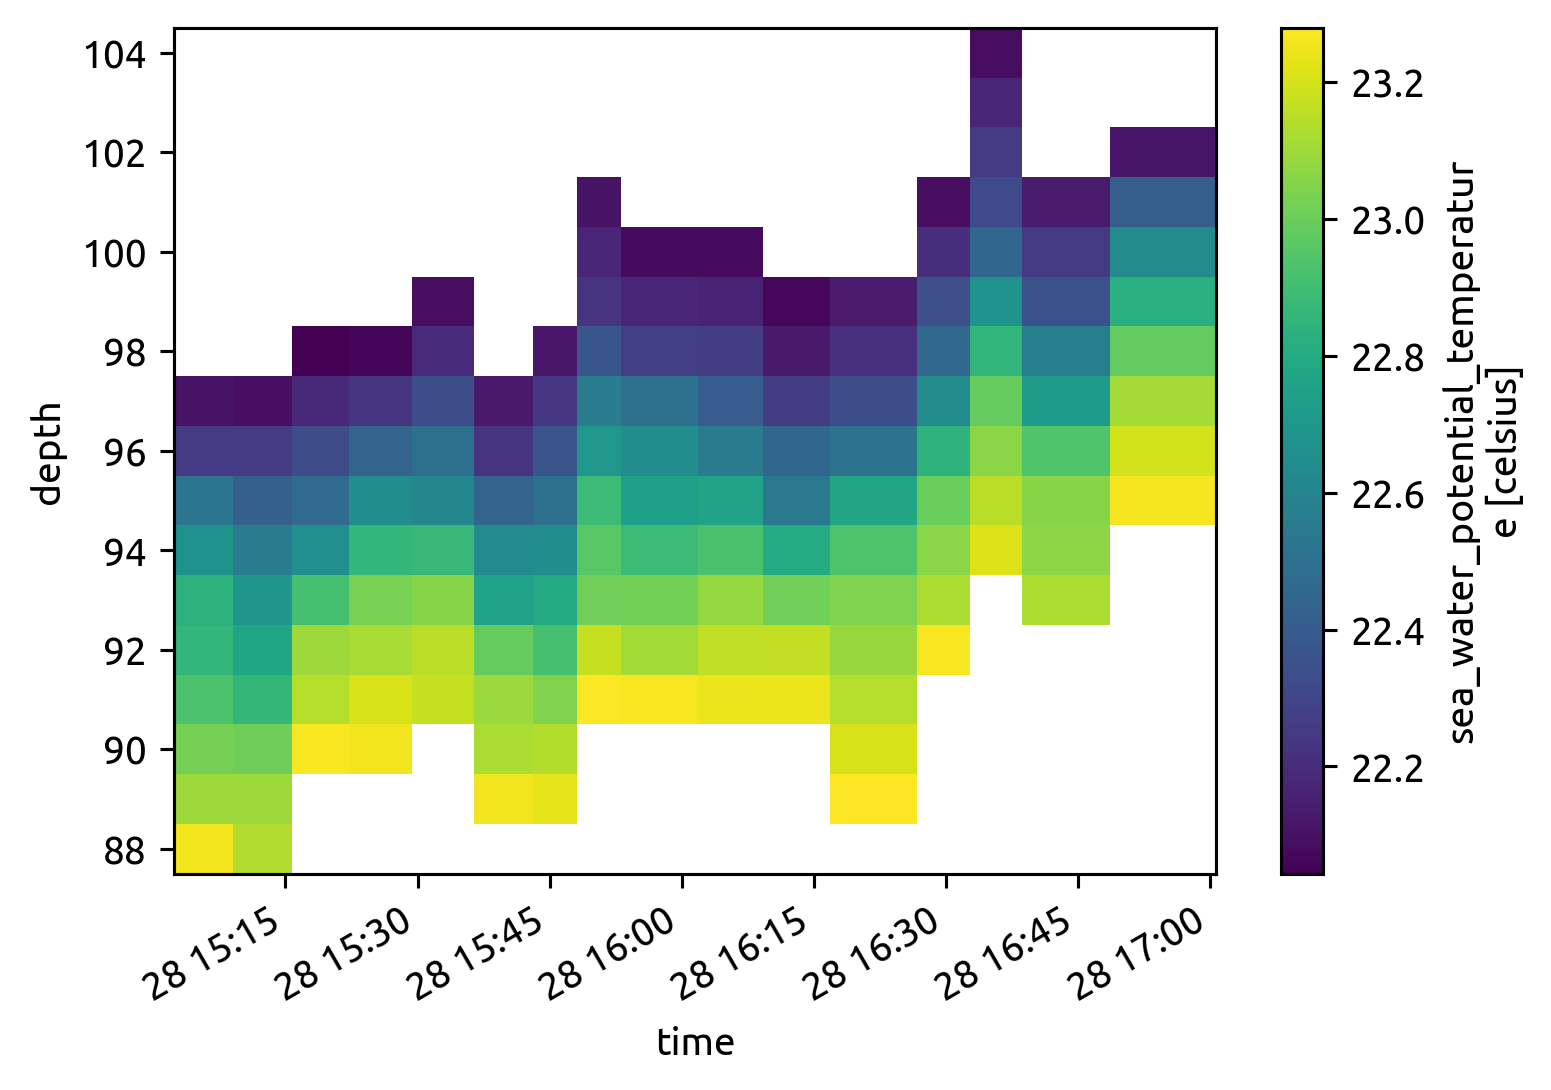

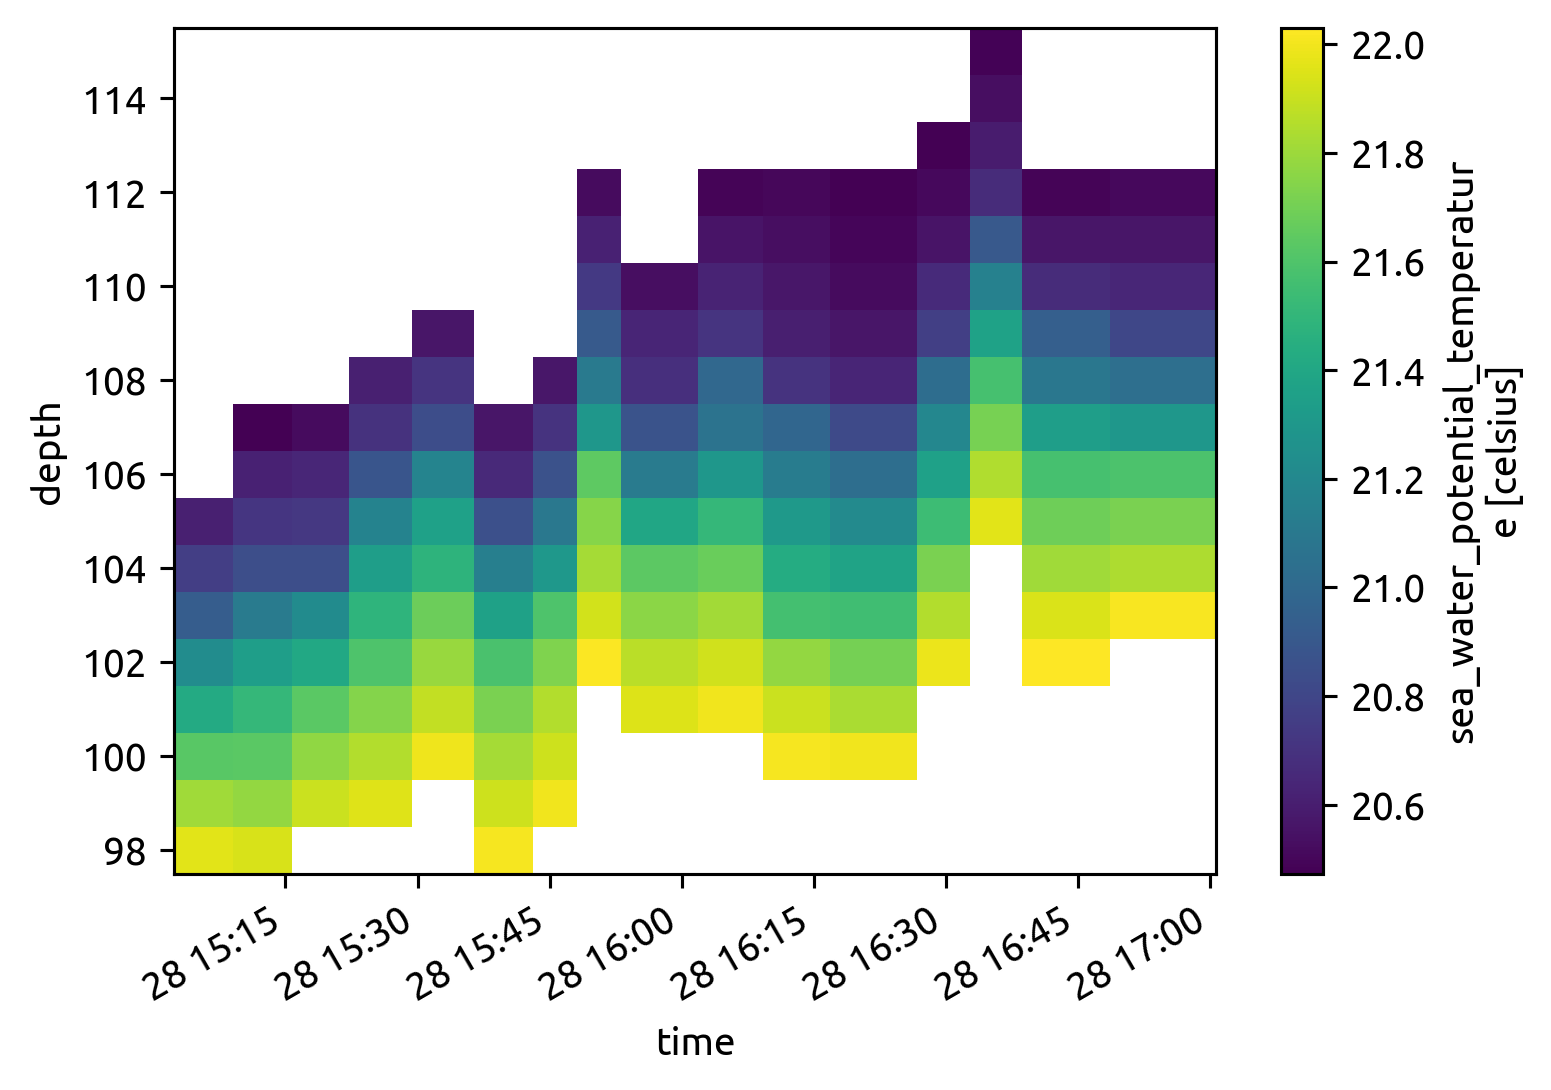

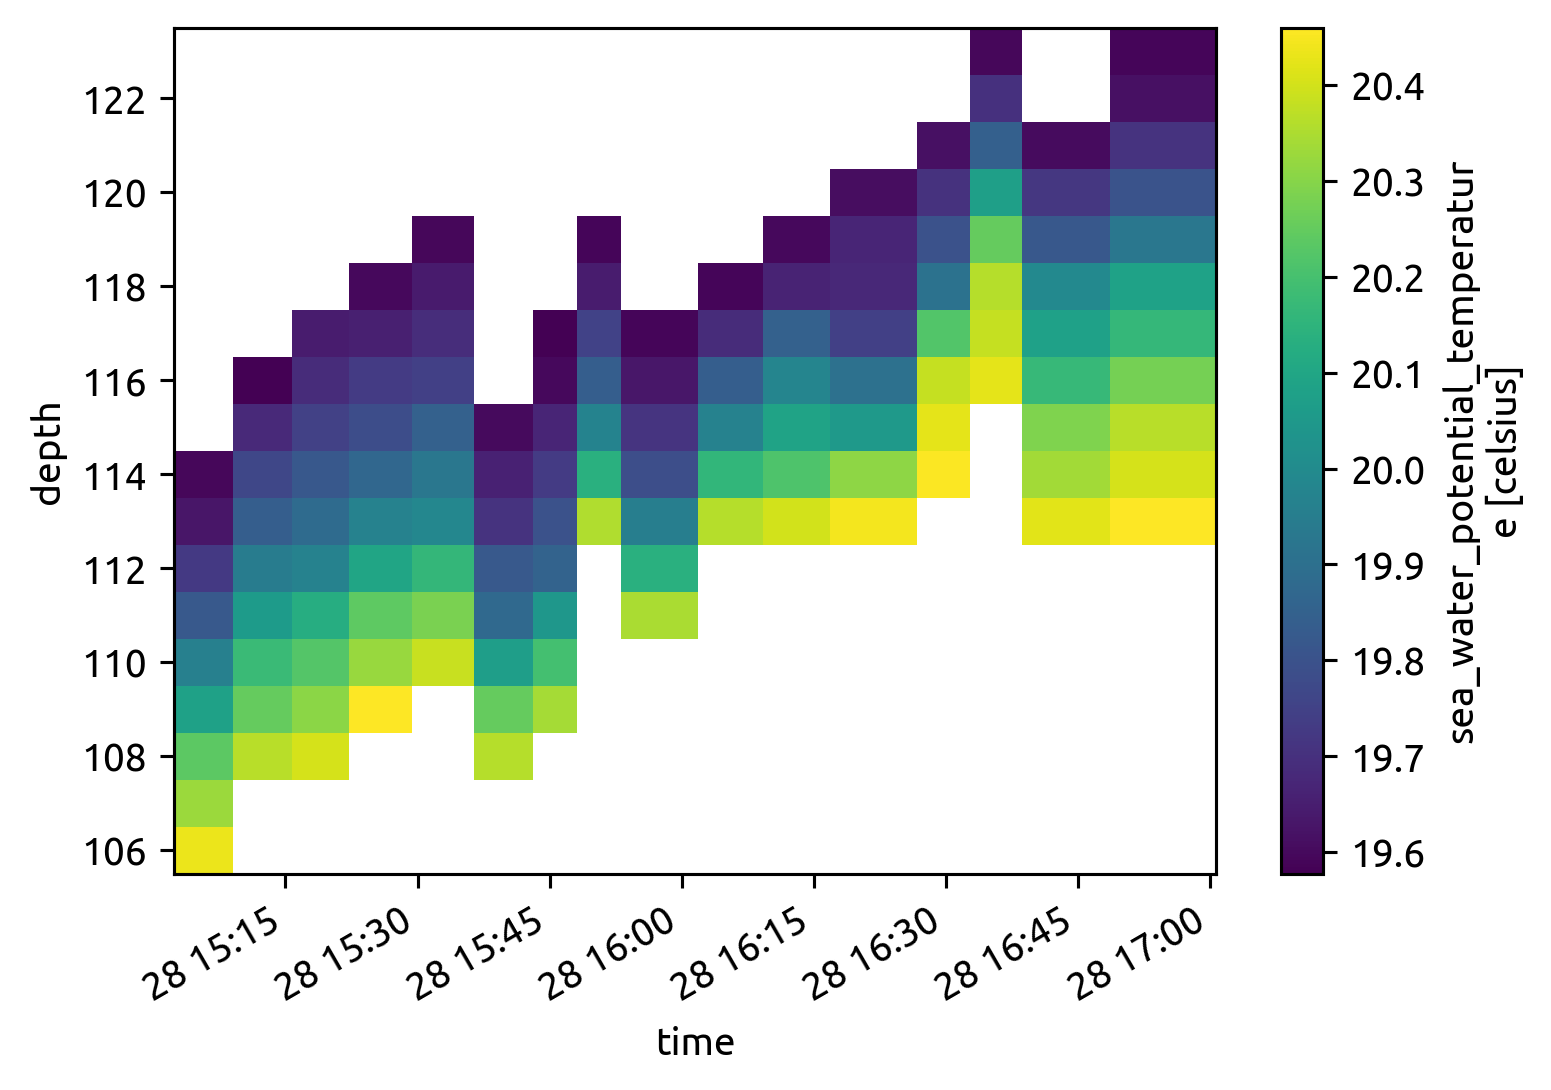

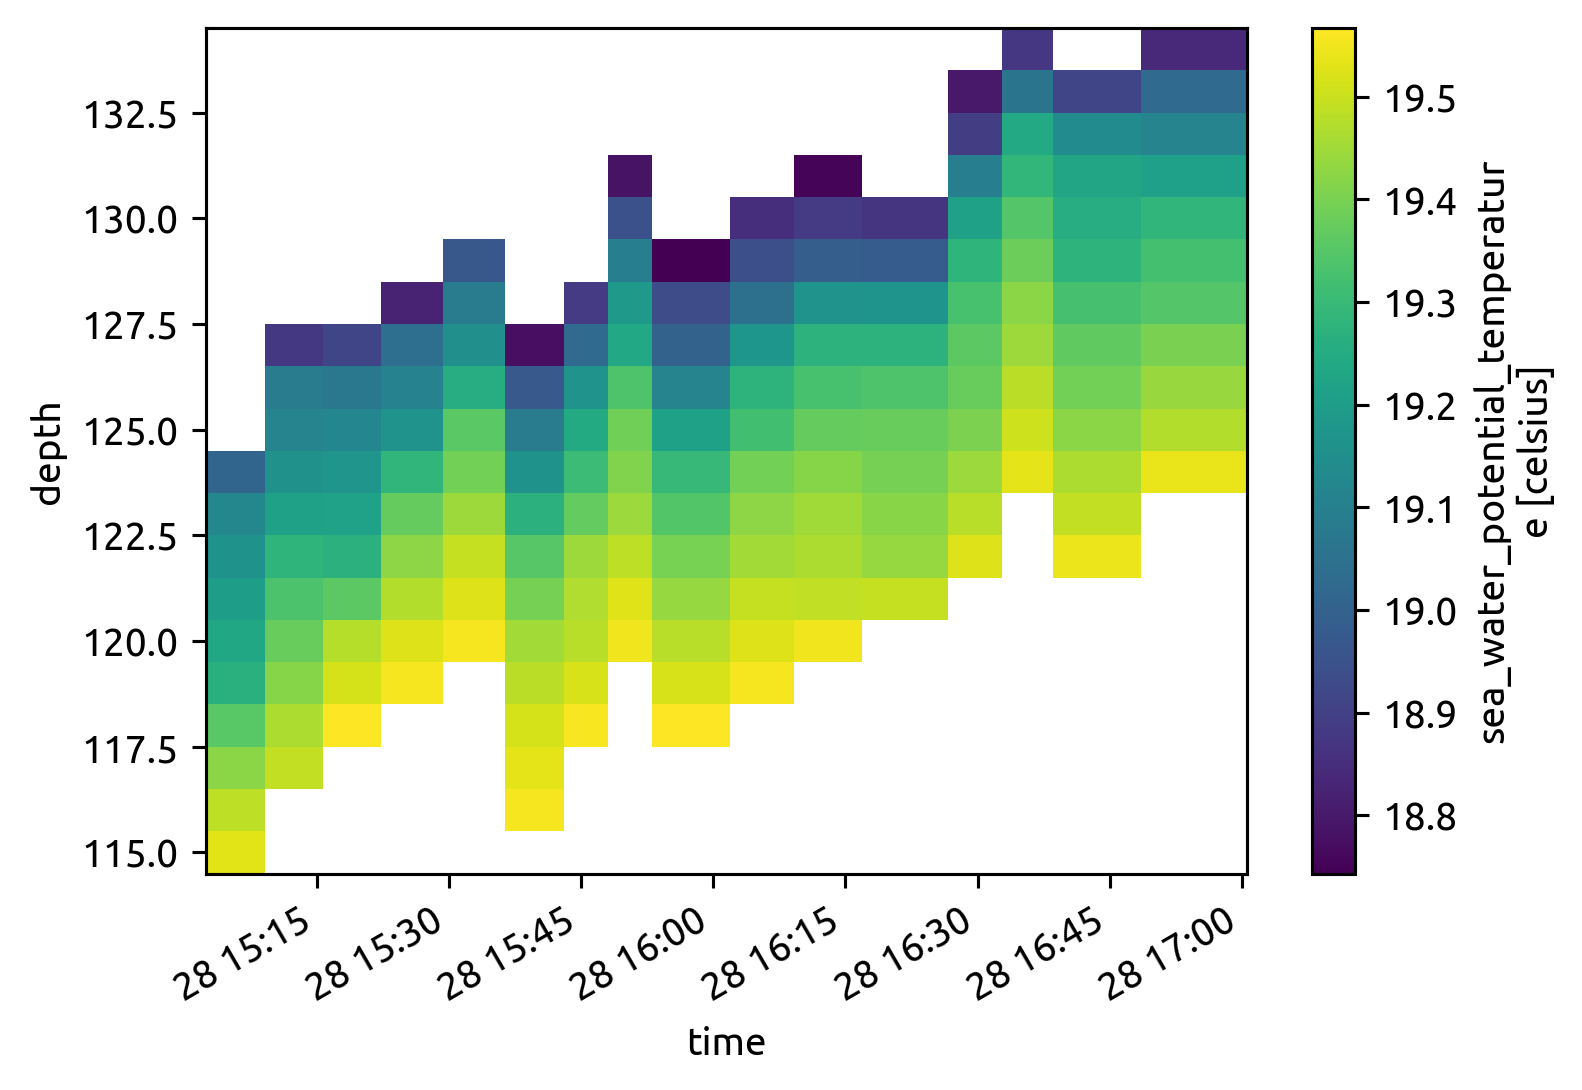

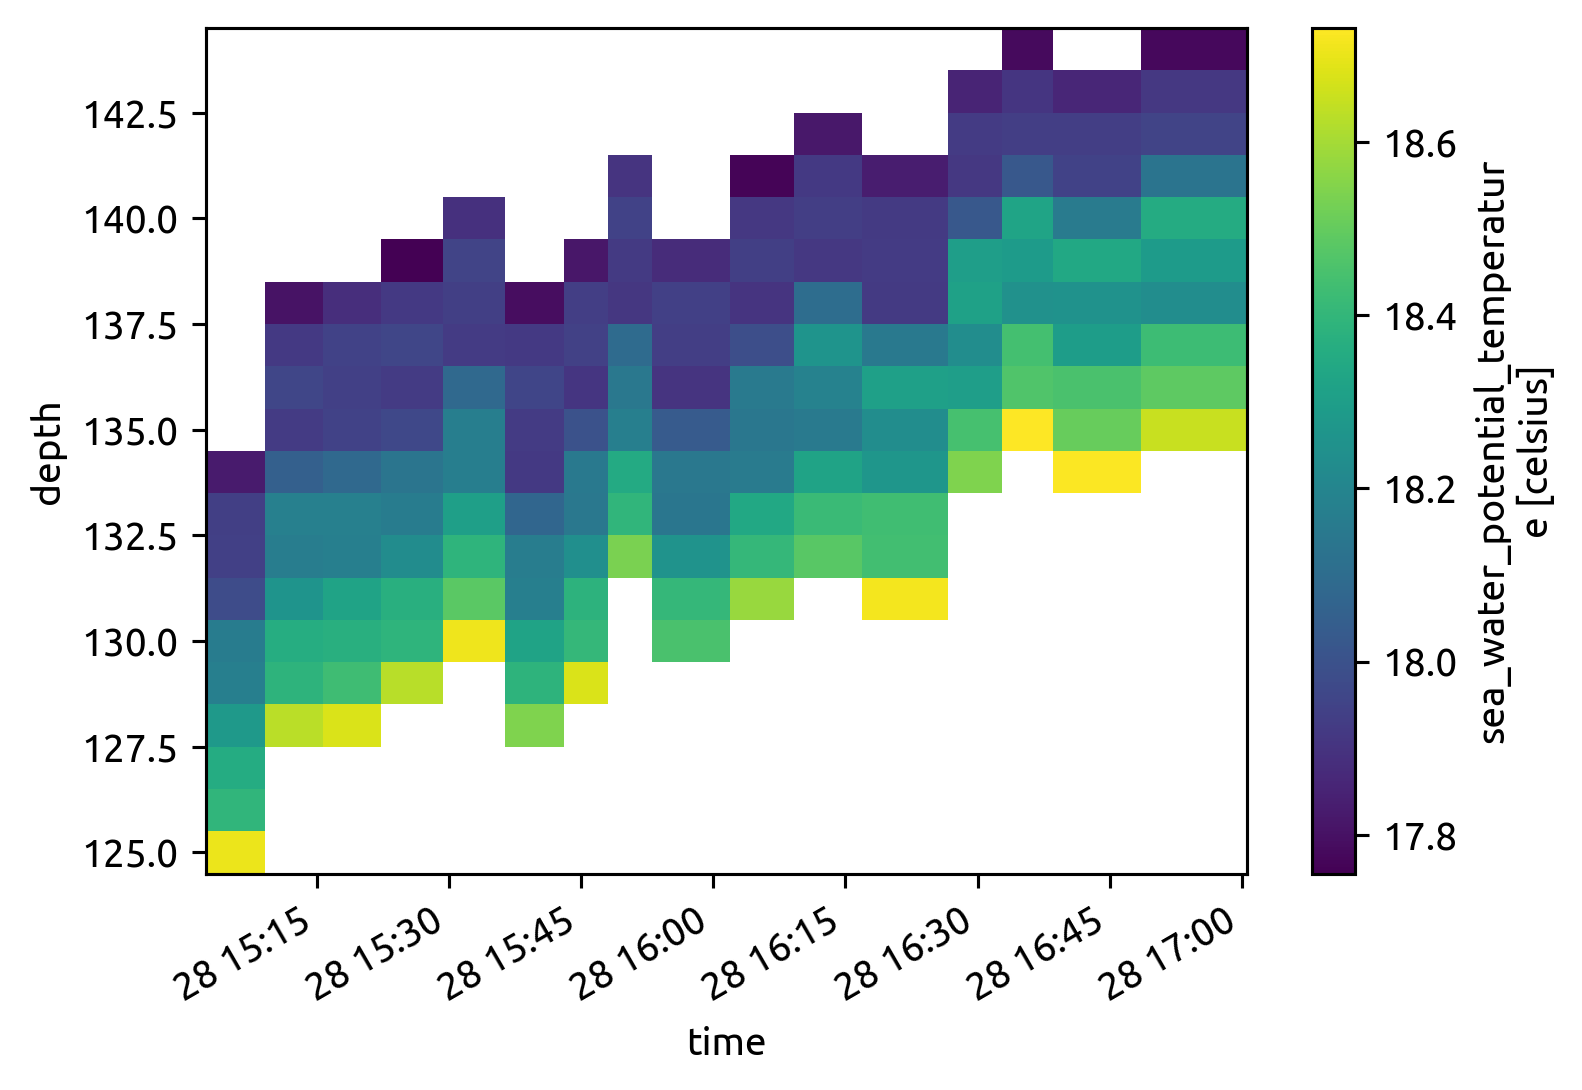

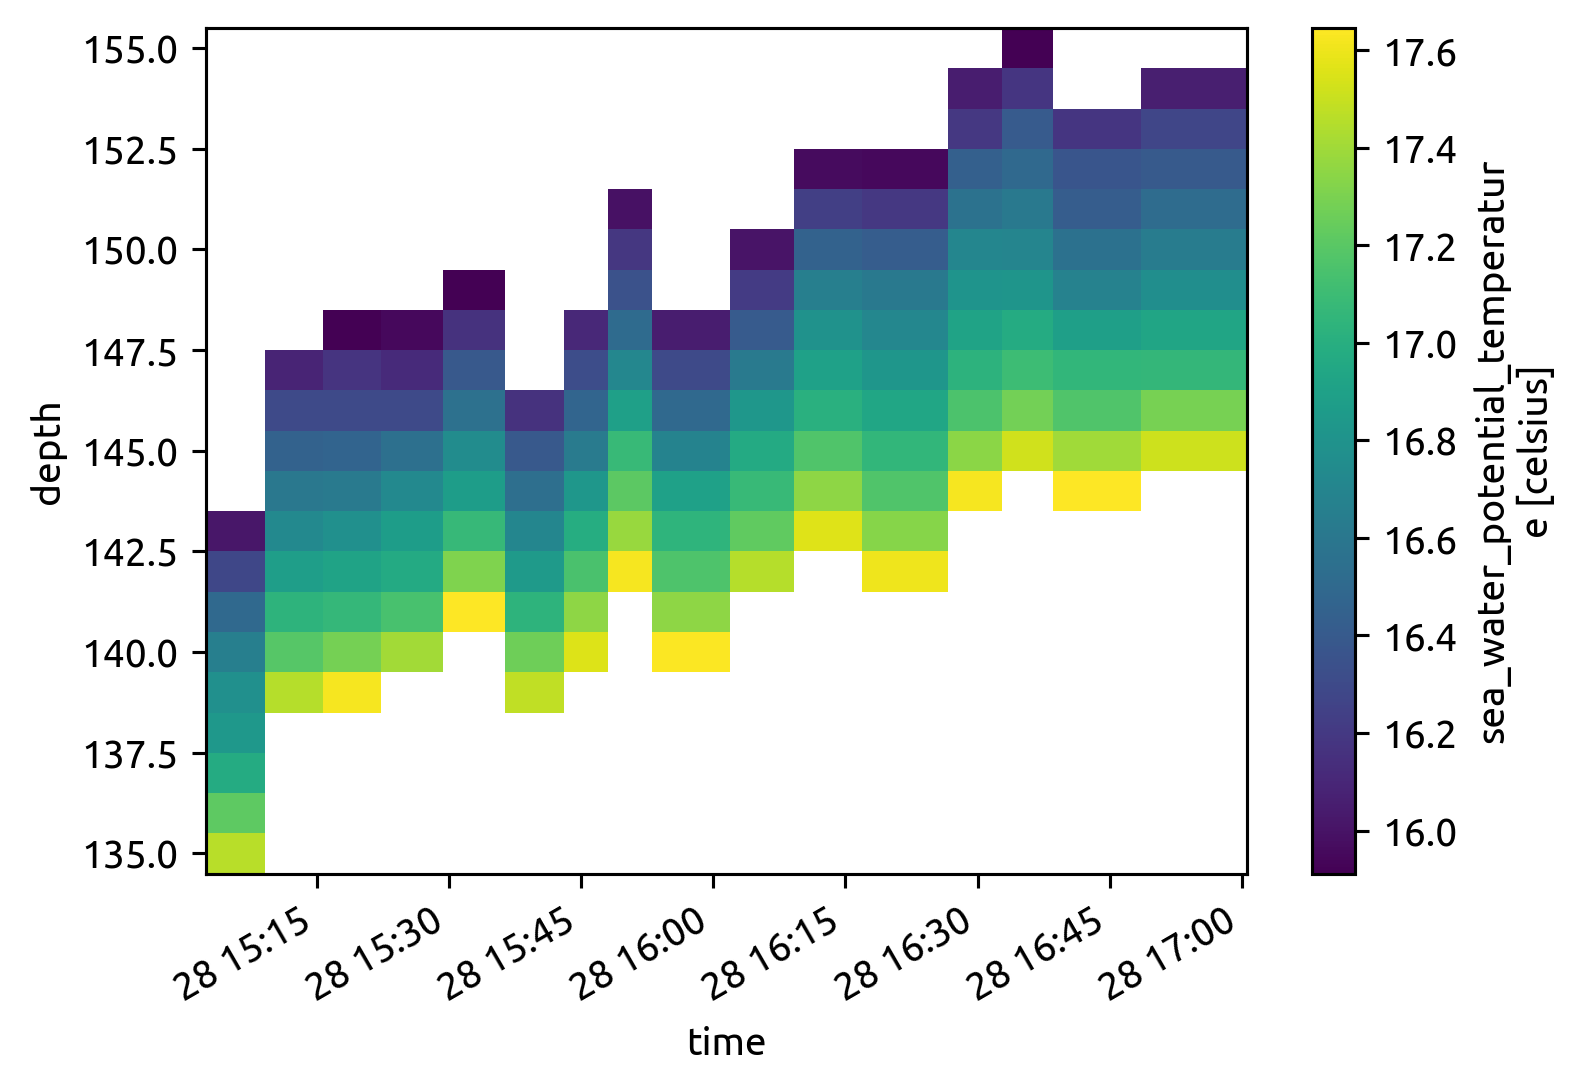

In [116]:
grouped = profiles[["theta", "pres"]].groupby_bins(
    "theta",
    bins=[
        15.907089928406089,
        17.714689412287875,
        18.738837135874356,
        19.568545699014813,
        20.46308786248256,
        22.030753182245434,
        23.294708796016472,
        23.952971257566002,
        24.470090072365664,
        24.806406274155623,
        24.956165806597976,
        25.031831248699703,
        25.060475714800504,
        25.070813151959925,
    ],
)


dzs = []

for label, group in grouped:
    Tmean = (label.left + label.right) / 2
    temp = group.unstack().theta
    plt.figure(); temp.plot()

    Δt = (temp.time[-1] - temp.time[0]).astype(int)

    dzs.append(
        xr.Dataset(
            {
                "mean": get_avg_dz(group),
                "conservative": -1
                * (temp.fillna(0) - temp.min()).interpolate_na("depth").integrate(["time", "depth"])
                / Δt
                / Tmean,
            }
        )
    )

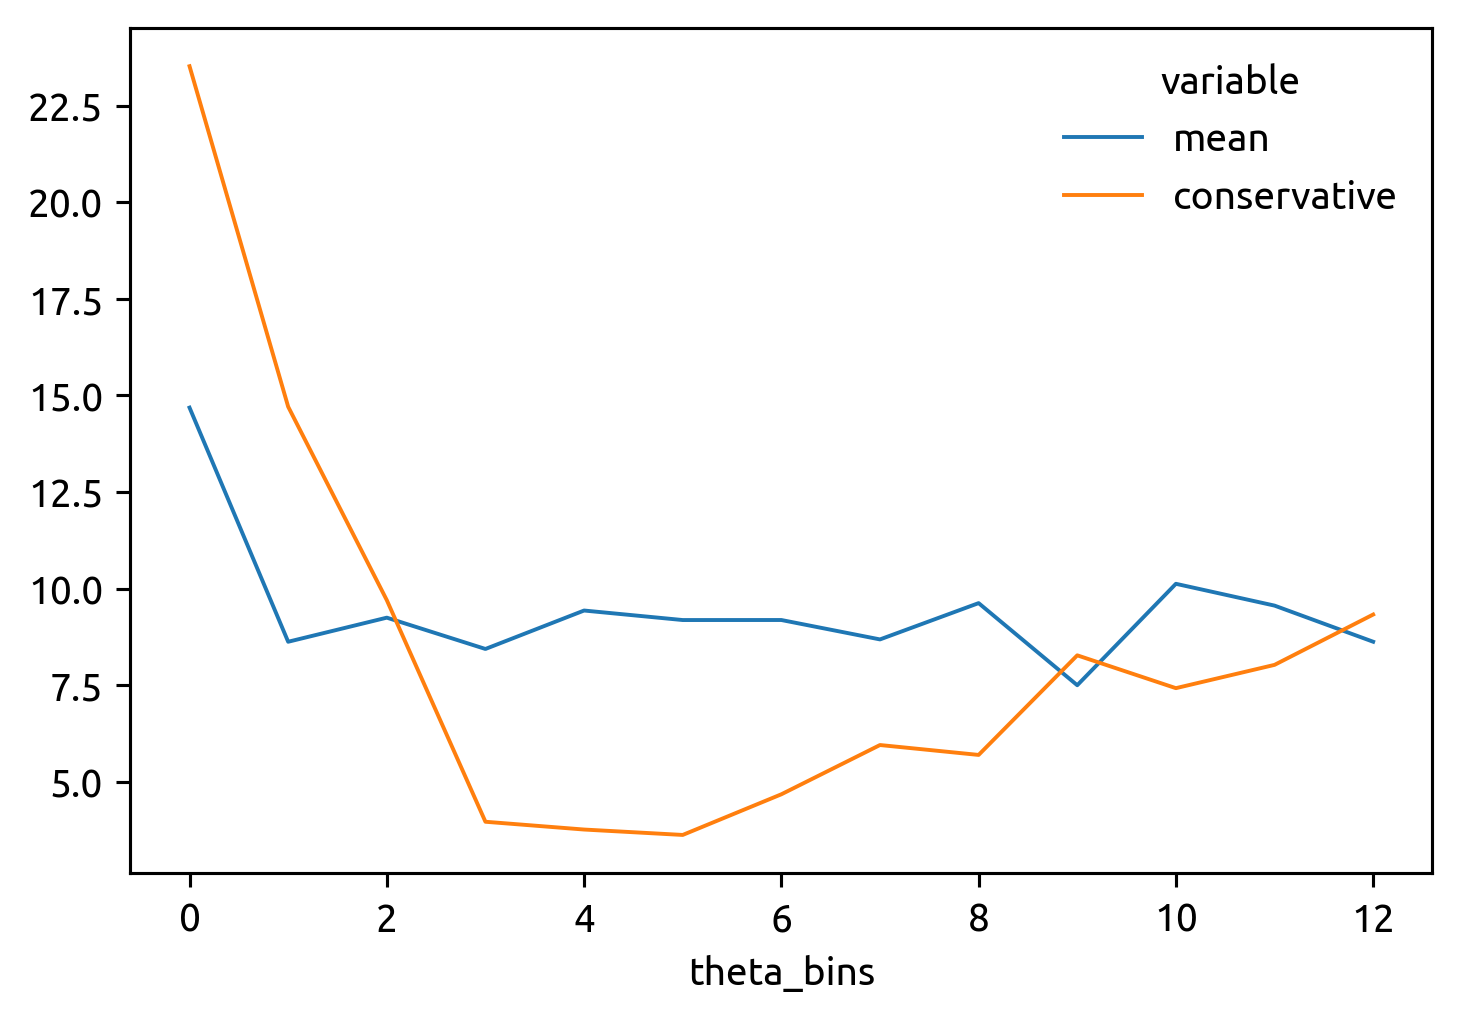

In [117]:
xr.concat(dzs, dim="theta_bins").to_array().plot(hue="variable")

## Chameleon vs χpod: dJ/dz